# Kaggle - Fraud detection in credit card transactions

## Load required packages

In [1]:
required_packages <- c( 
  # Add to this list the packages that you will use - if unavailable, it will be 
  # automatically installed
    "Hmisc",
    "caret",
    "kknn",
    "gbm",
    "nnet",
    "h2o",
    "xgboost",
    "lightgbm",
    "mlr",
    "parallel",
    "parallelMap",
    "ggplot2",
    "data.table",
    "tidyverse"
    )

  packages_to_install = required_packages[!(required_packages %in% 
                                                installed.packages()[, 1])]
    
  if (length(packages_to_install) > 0) {
    install.packages(packages_to_install)
  }
    
  suppressPackageStartupMessages({
    sapply(required_packages, require, character.only = TRUE)
  })

Hmisc       caret        kknn         gbm        nnet         h2o 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
    xgboost    lightgbm         mlr    parallel parallelMap     ggplot2 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
 data.table   tidyverse 
       TRUE        TRUE

# Import the data

In [2]:
df <- fread("creditcard.csv") #Use fread() from the data.table package to read in large datasets

Read 284807 rows and 31 (of 31) columns from 0.140 GB file in 00:00:12


In [3]:
df <- df %>% 
  data.frame() %>% 
  mutate(Class = as.factor(Class)) ##Convert target variable to categorical type

In [4]:
head(df)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,...,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,...,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,...,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,...,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,...,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,...,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


# Split data into train and test dataset

Let us split our dataset into one train and one out-of-sample test dataset, because that's how real life scenarios will be - you never know what your test data will look like

In [5]:
#Set seed for random sampling
set.seed(42)

trainIndex <- createDataPartition(df$Class, 
                                  p = 0.8, #Proportion of training data
                                  list = FALSE, 
                                  times = 1)

df_train <- df[trainIndex,]
df_test  <- df[-trainIndex,]

In [6]:
table(df_train$Class)/nrow(df_train)
table(df_test$Class)/nrow(df_test)


          0           1 
0.998270762 0.001729238 


          0           1 
0.998279525 0.001720475 

## Exploratory Data Analysis

In [9]:
describe(df)

df 

 31  Variables      284807  Observations
--------------------------------------------------------------------------------
Time 
      n missing  unique    Info    Mean     .05     .10     .25     .50     .75 
 284807       0  124592       1   94814   25298   35027   54202   84692  139321 
    .90     .95 
 157640  164143 

lowest :      0      1      2      4      7
highest: 172785 172786 172787 172788 172792 
--------------------------------------------------------------------------------
V1 
        n   missing    unique      Info      Mean       .05       .10       .25 
   284807         0    275663         1 1.176e-15  -2.89915  -1.89327  -0.92037 
      .50       .75       .90       .95 
  0.01811   1.31564   2.01541   2.08122 

lowest : -56.408 -46.855 -41.929 -40.470 -40.043
highest:   2.431   2.439   2.447   2.452   2.455 
--------------------------------------------------------------------------------
V2 
        n   missing    unique      Info      Mean       .05       .

We see that there are no missing values in any of the columns in our dataset. Let us plot the distribution of these variables to see how they are distributed:

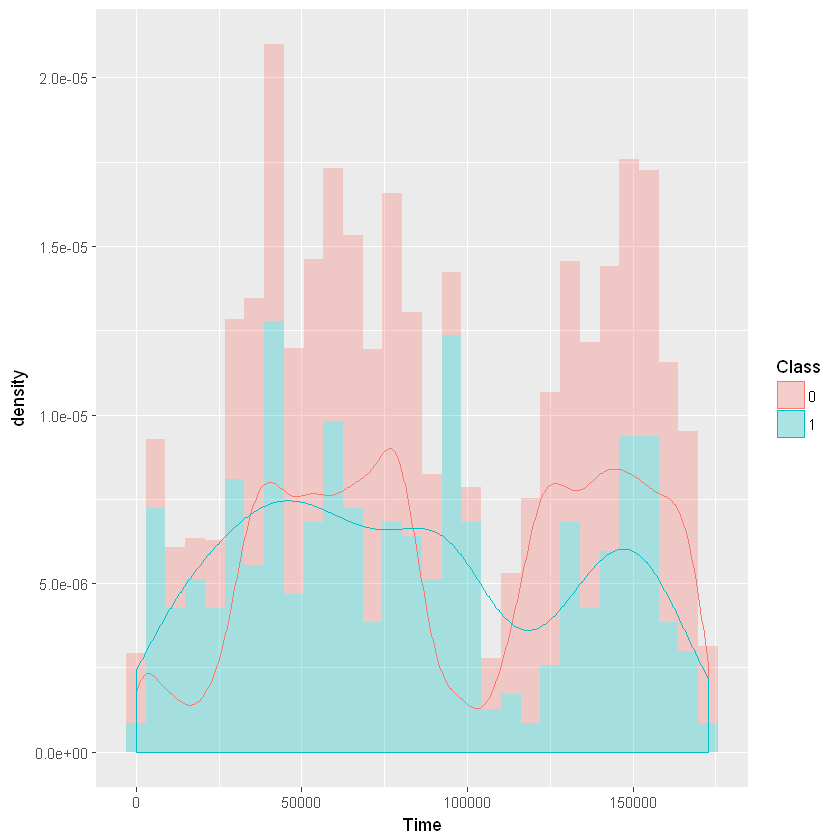

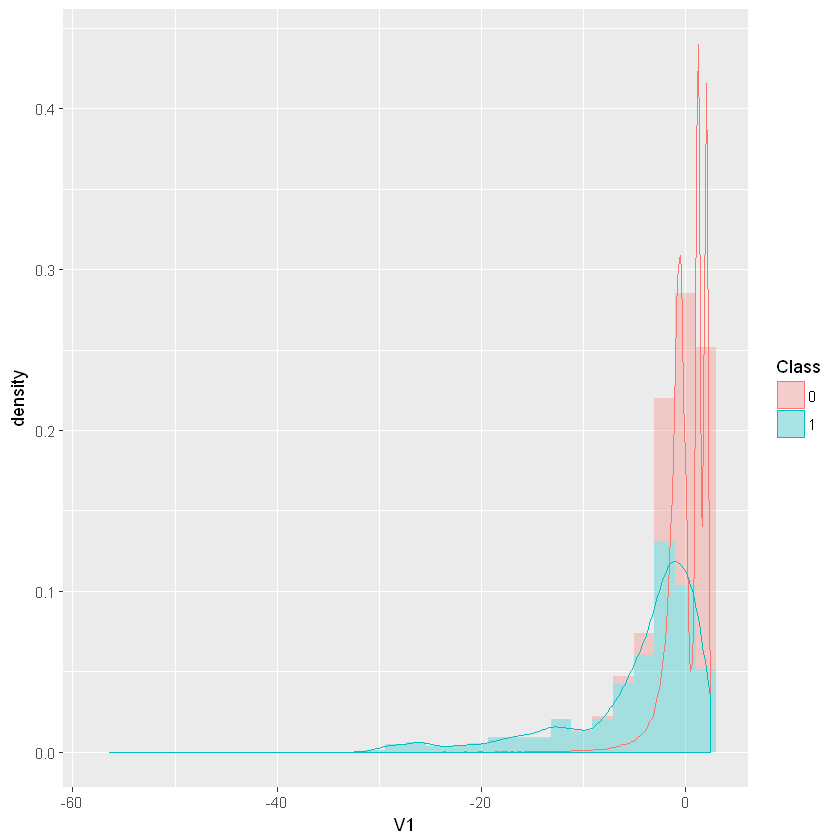

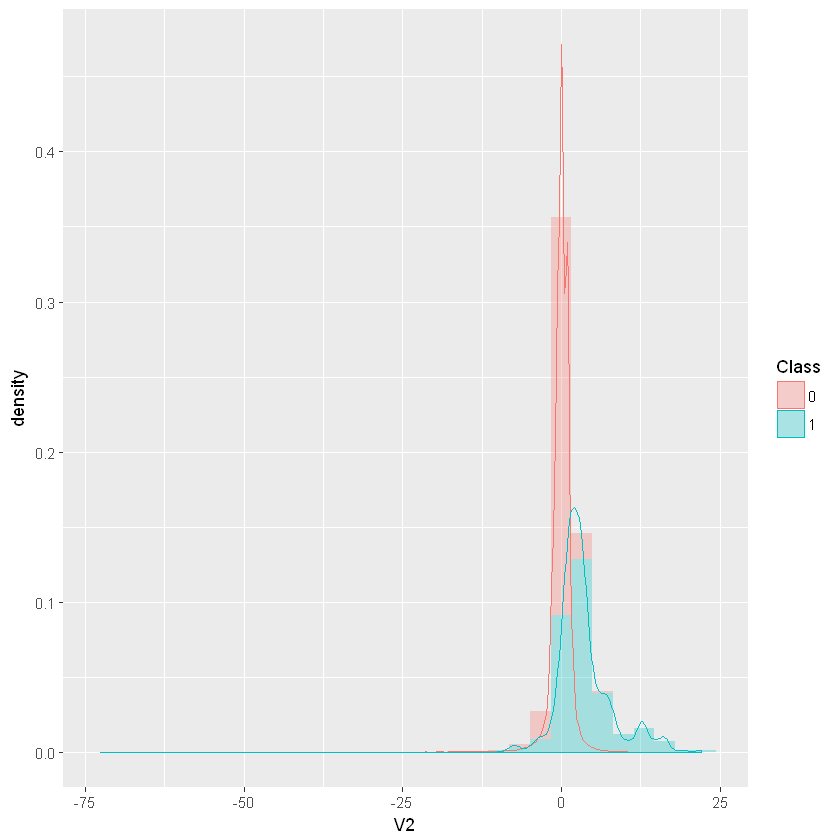

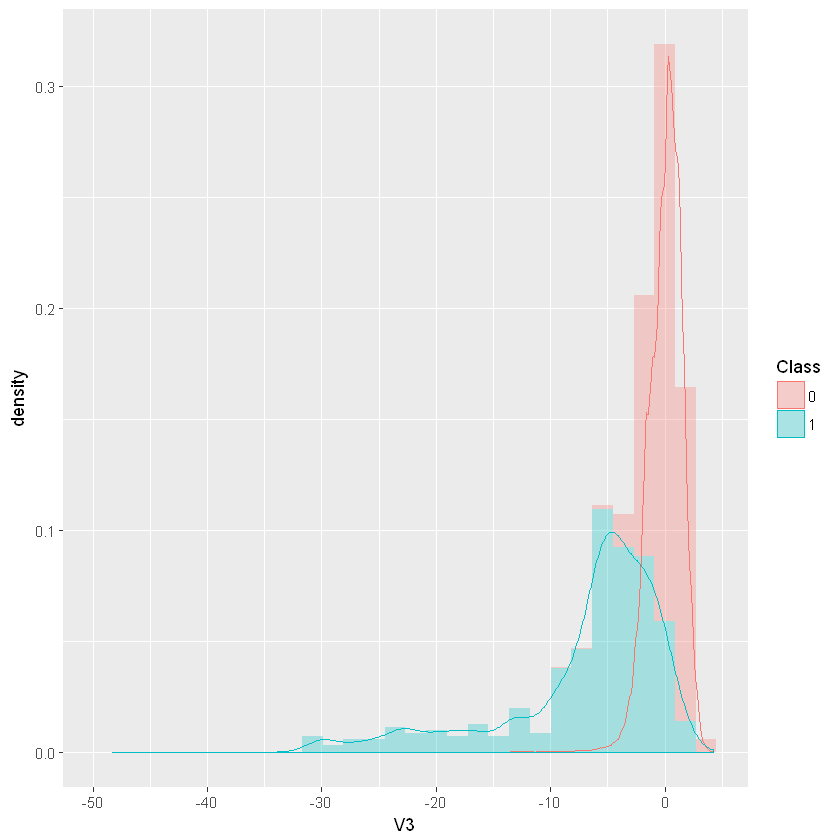

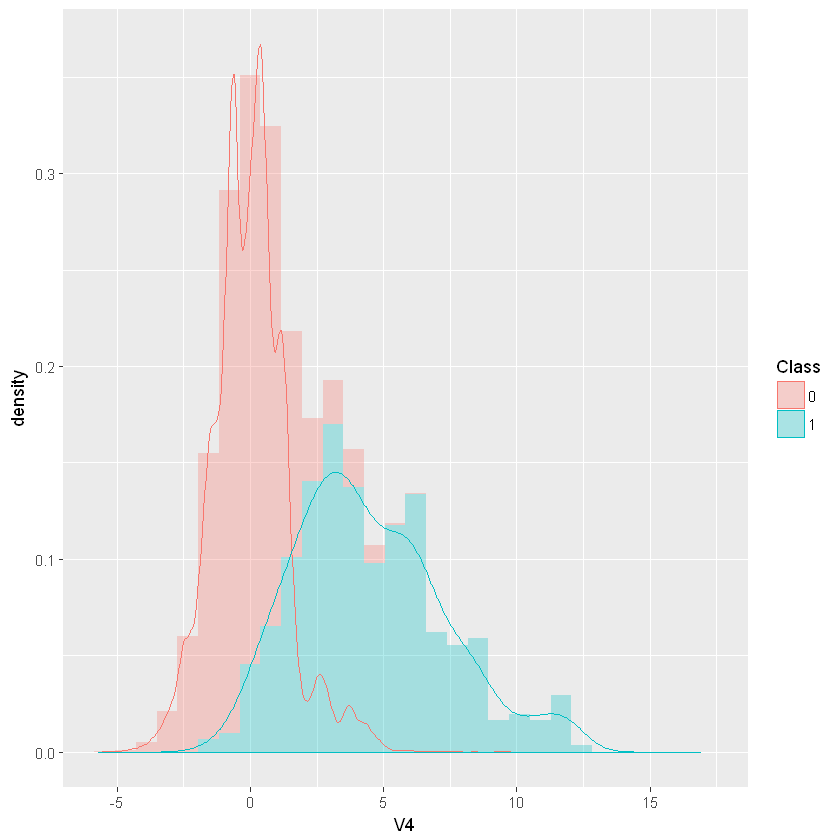

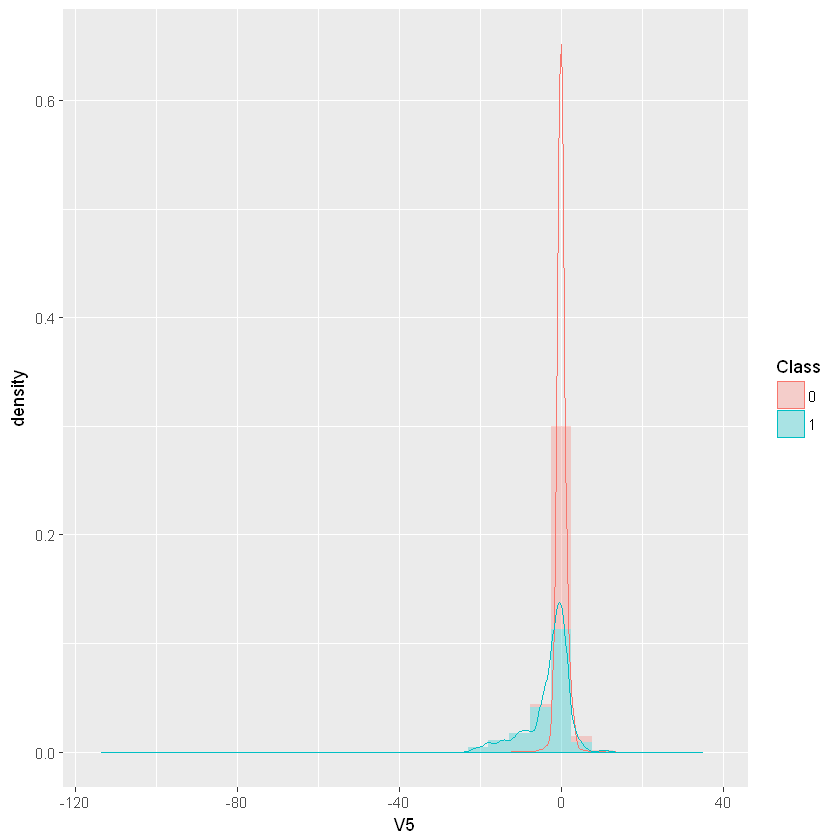

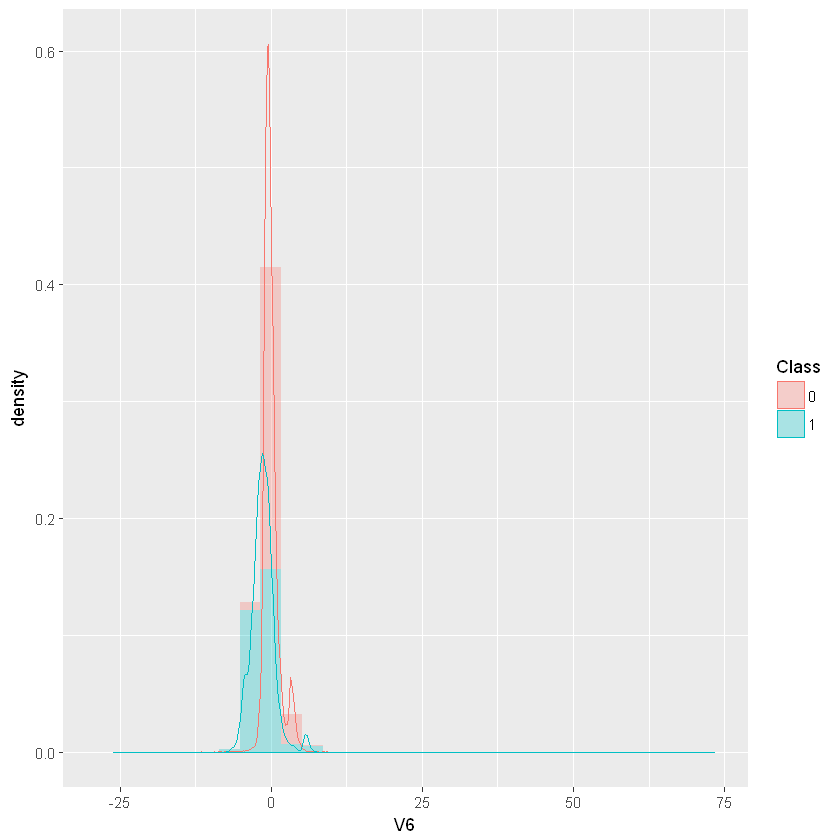

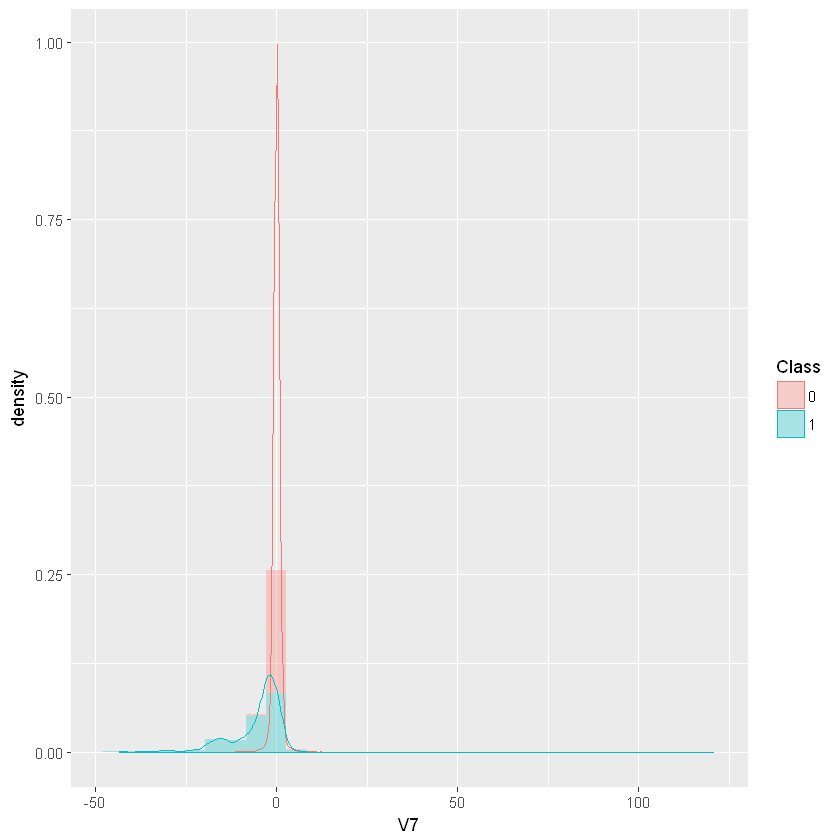

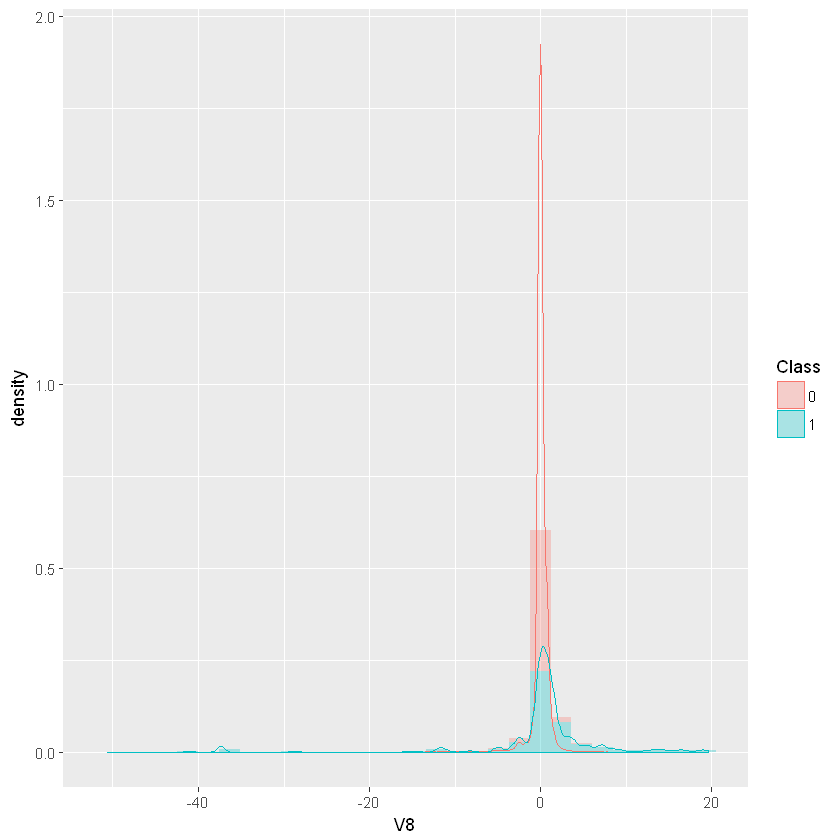

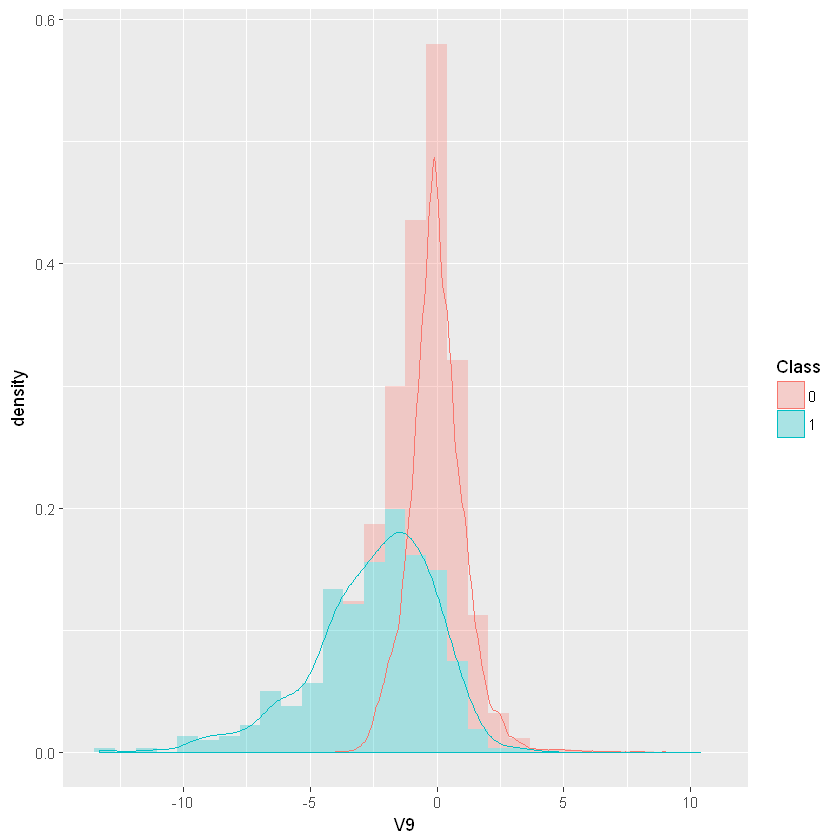

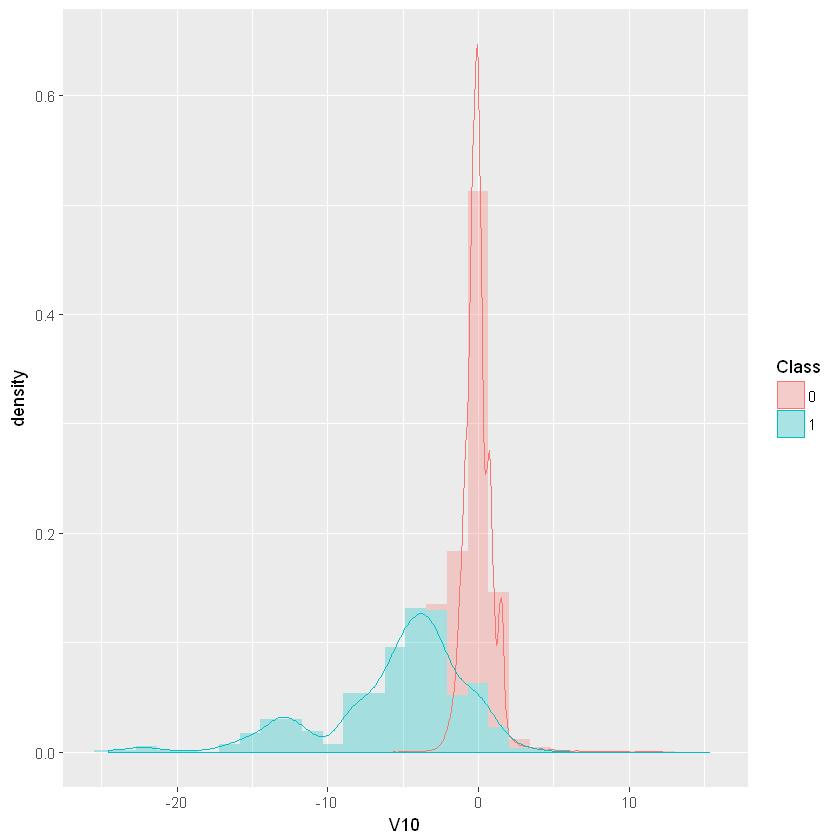

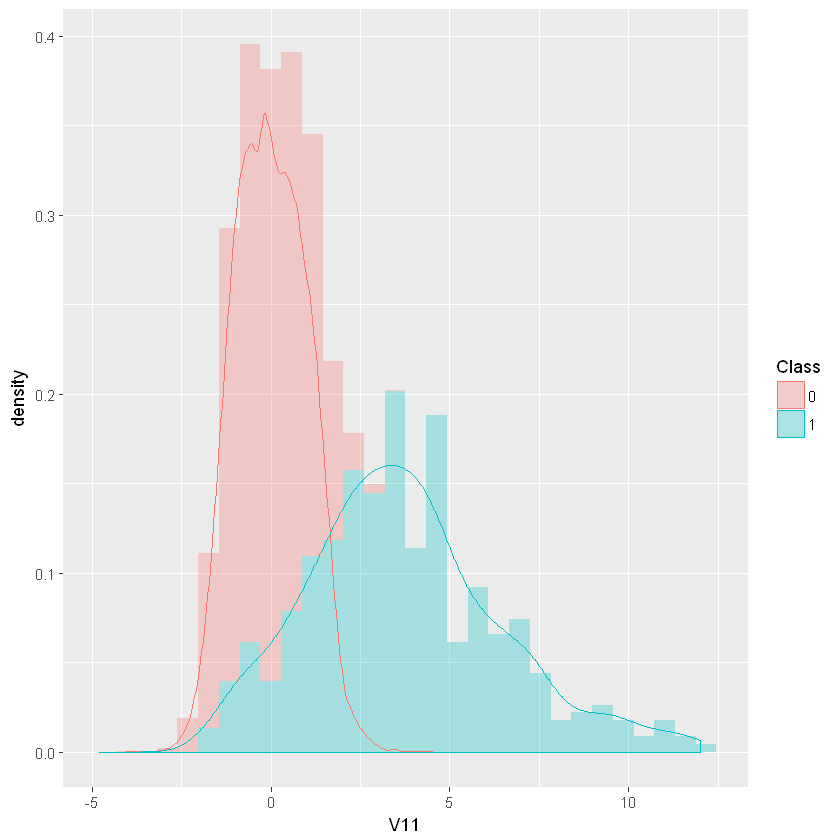

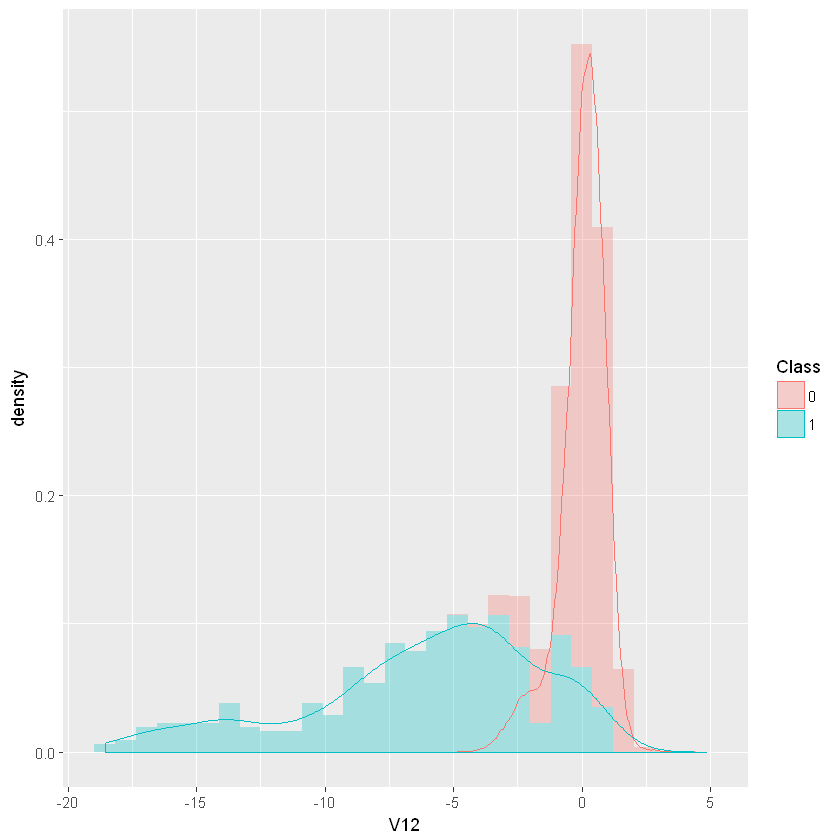

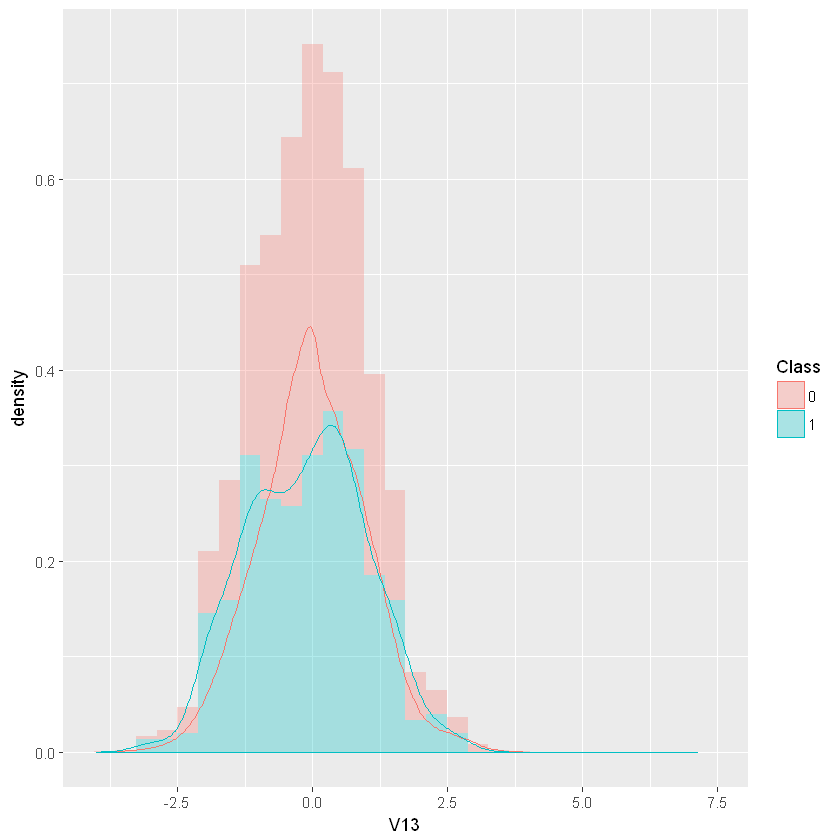

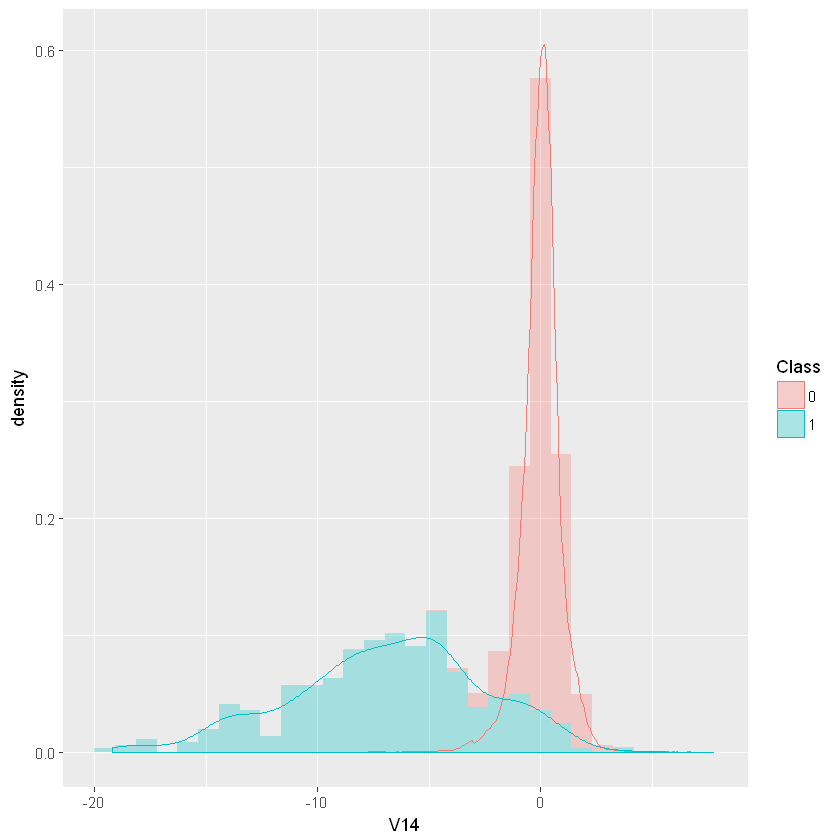

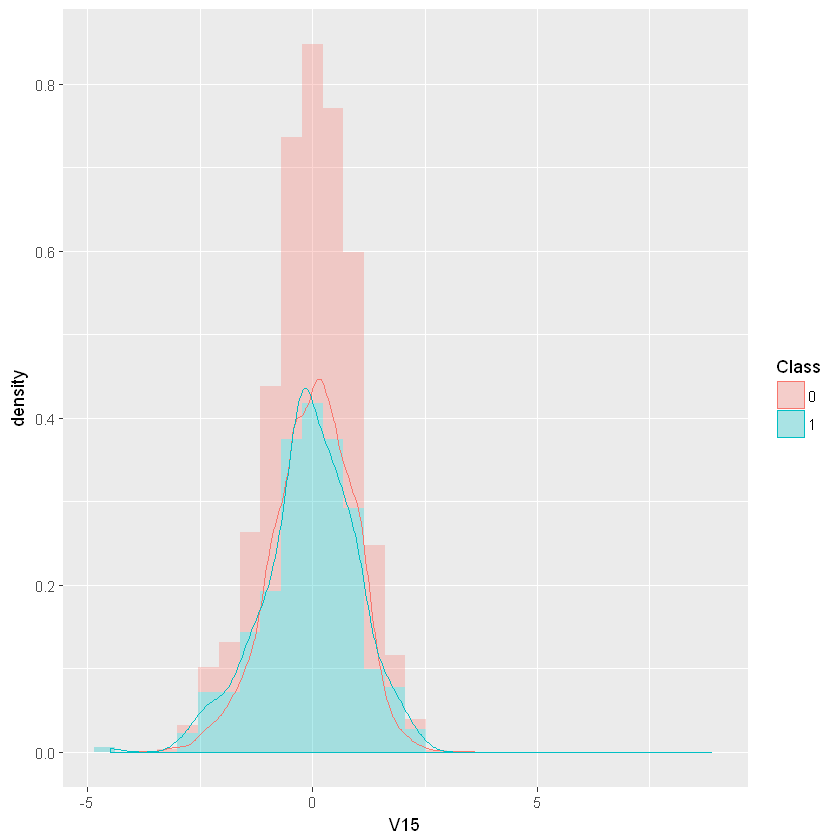

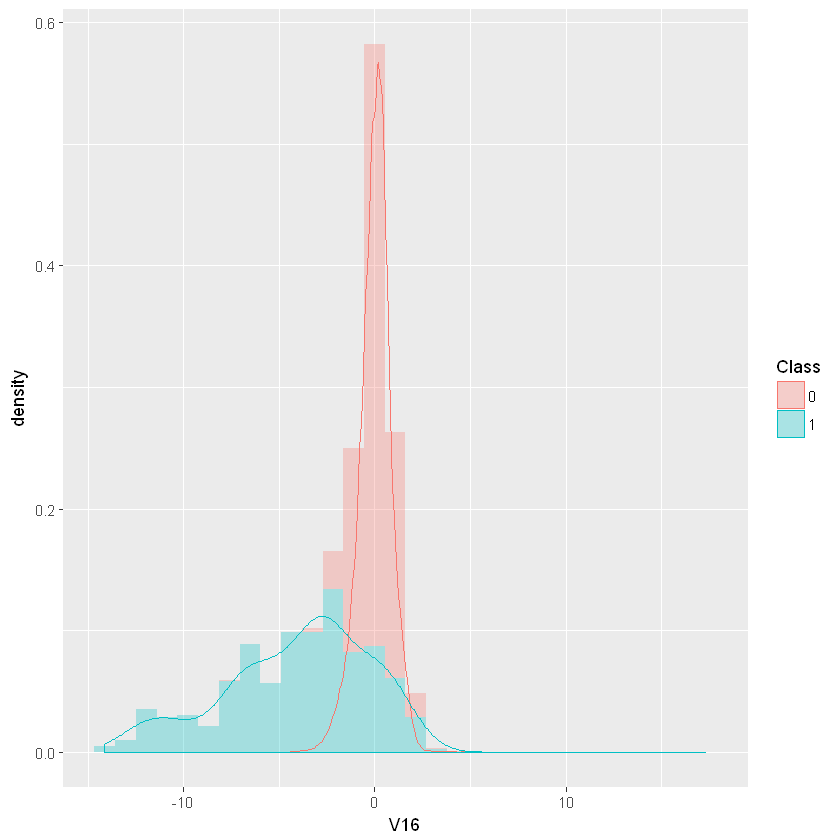

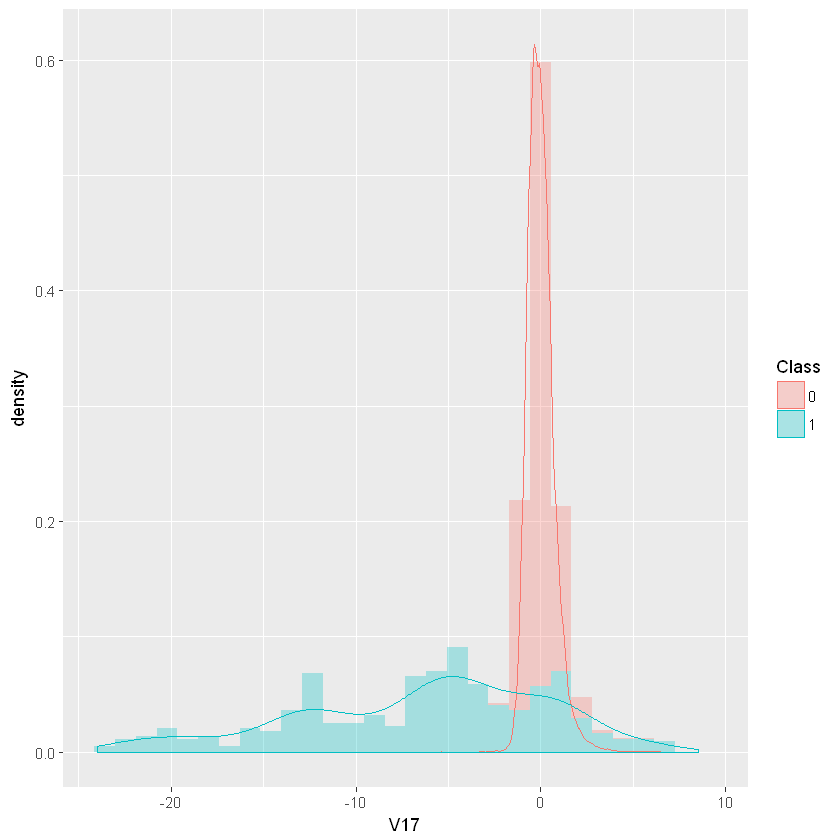

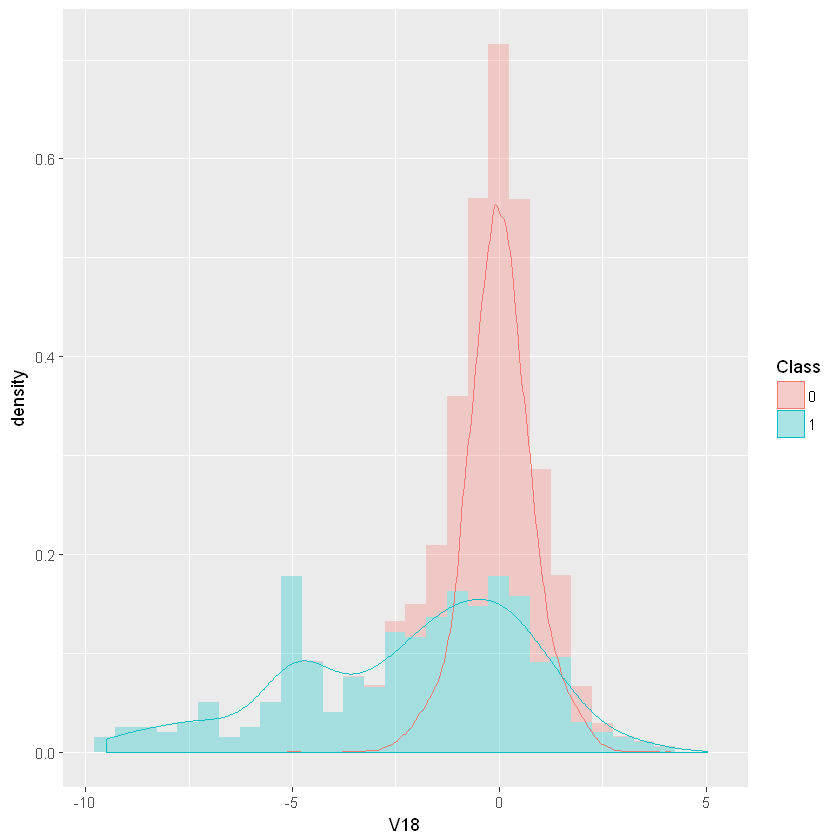

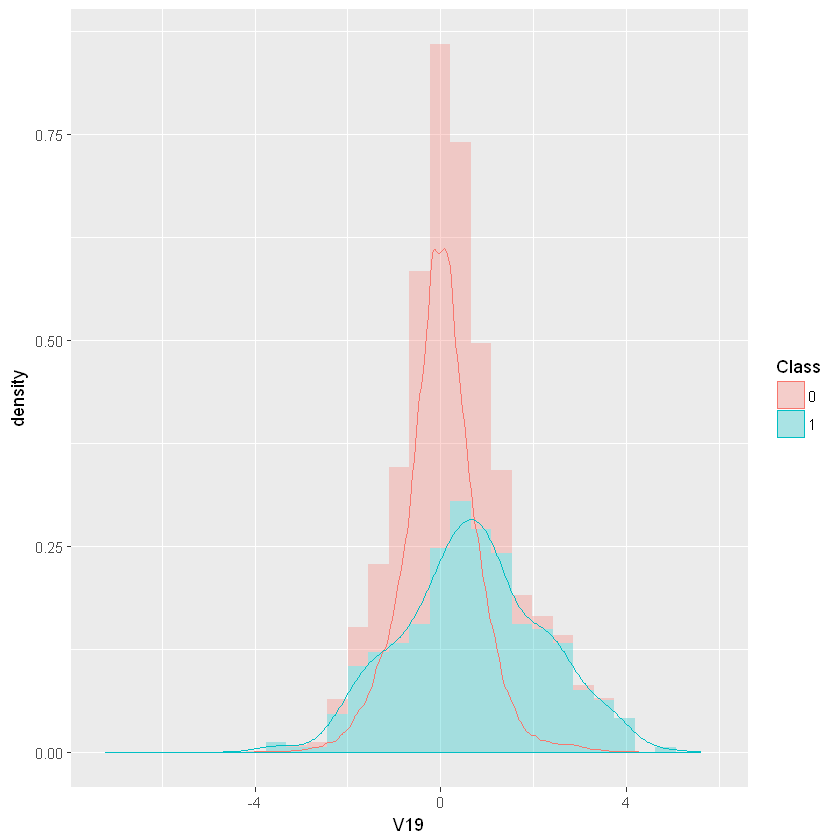

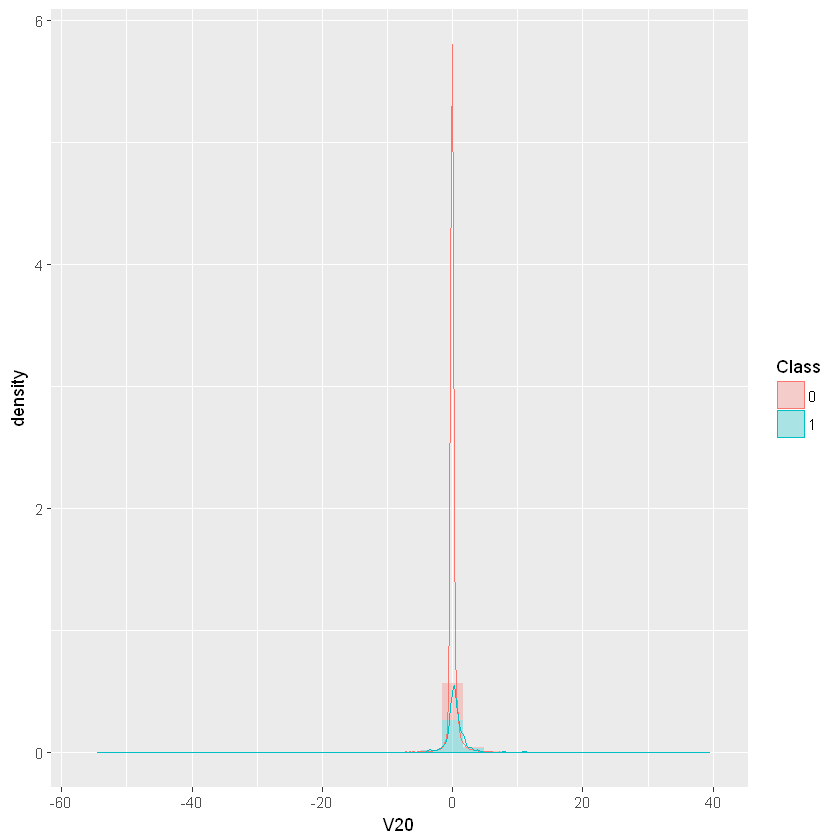

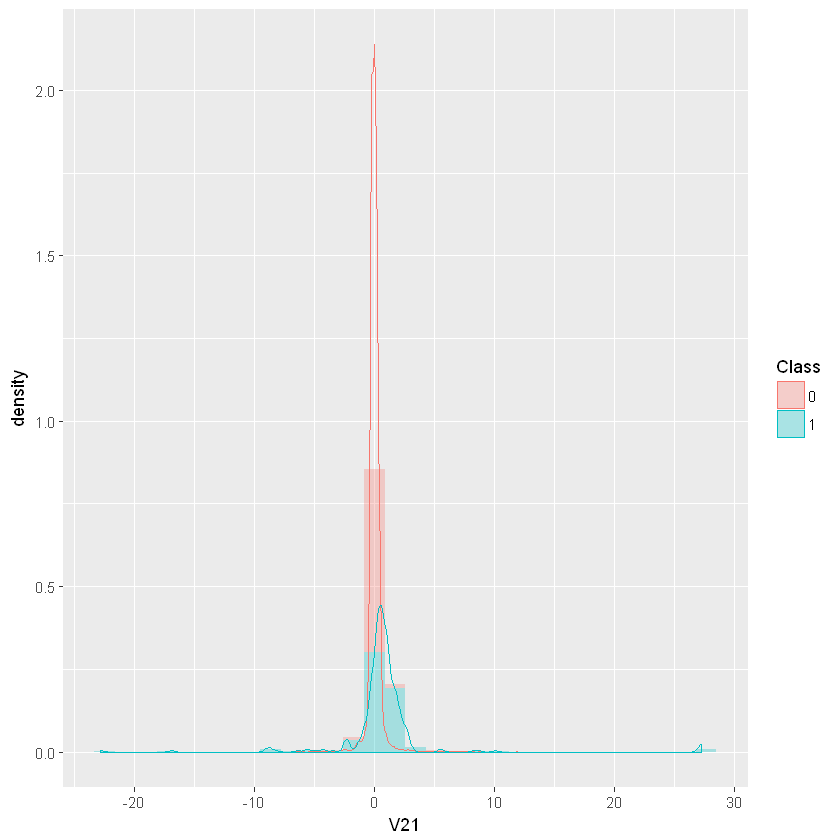

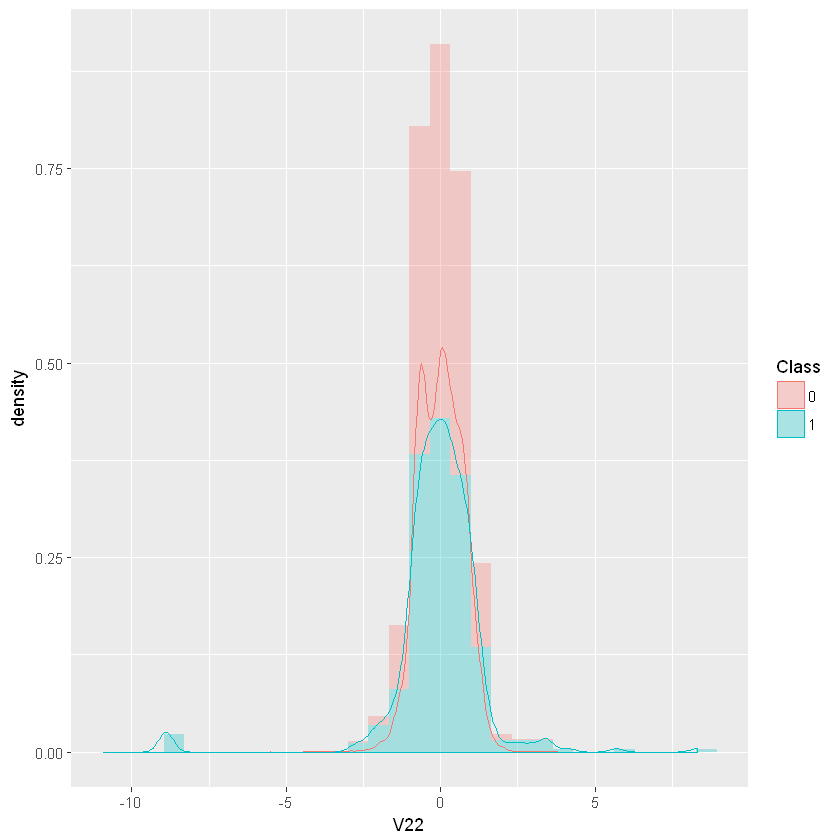

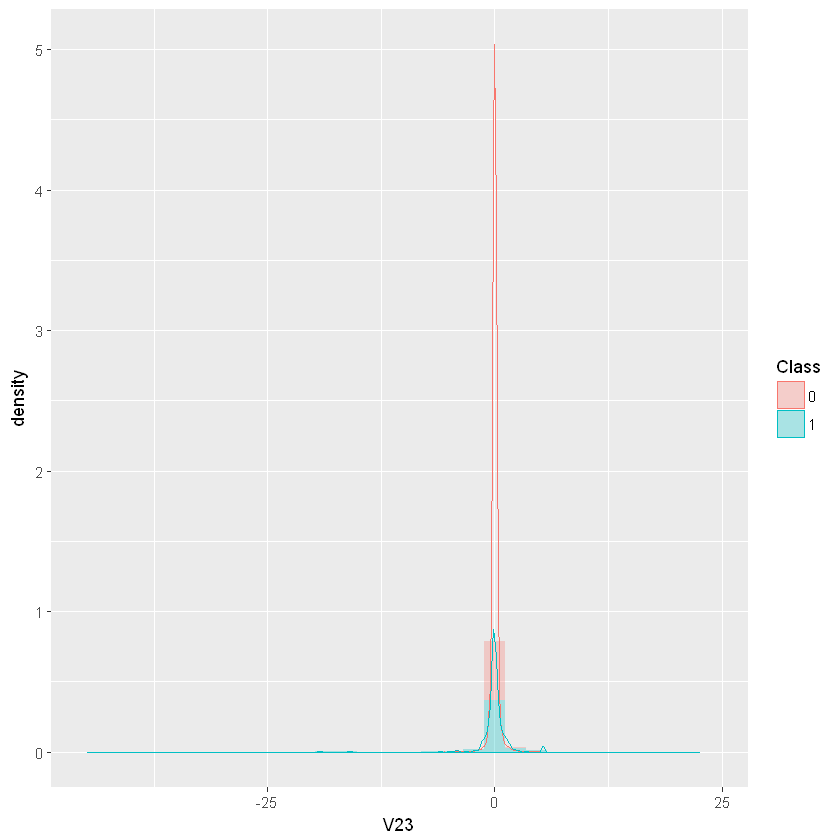

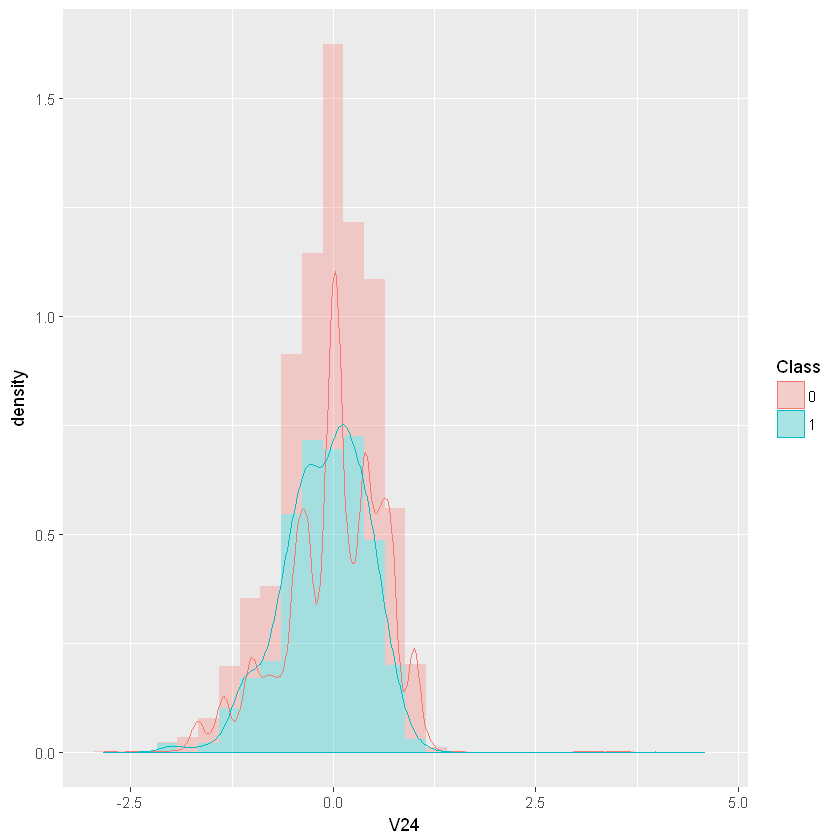

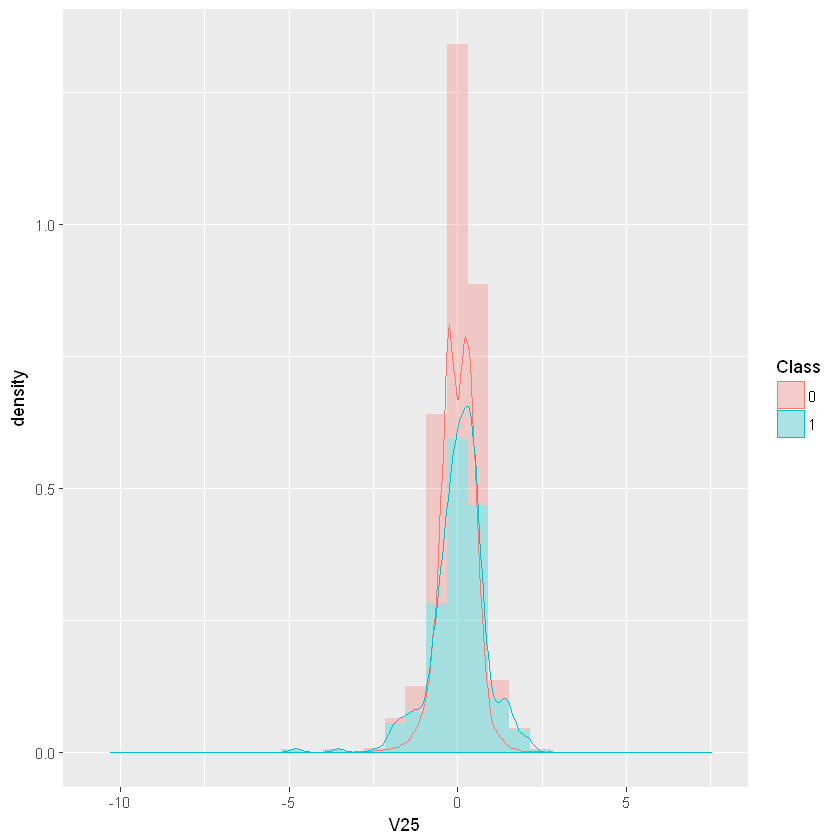

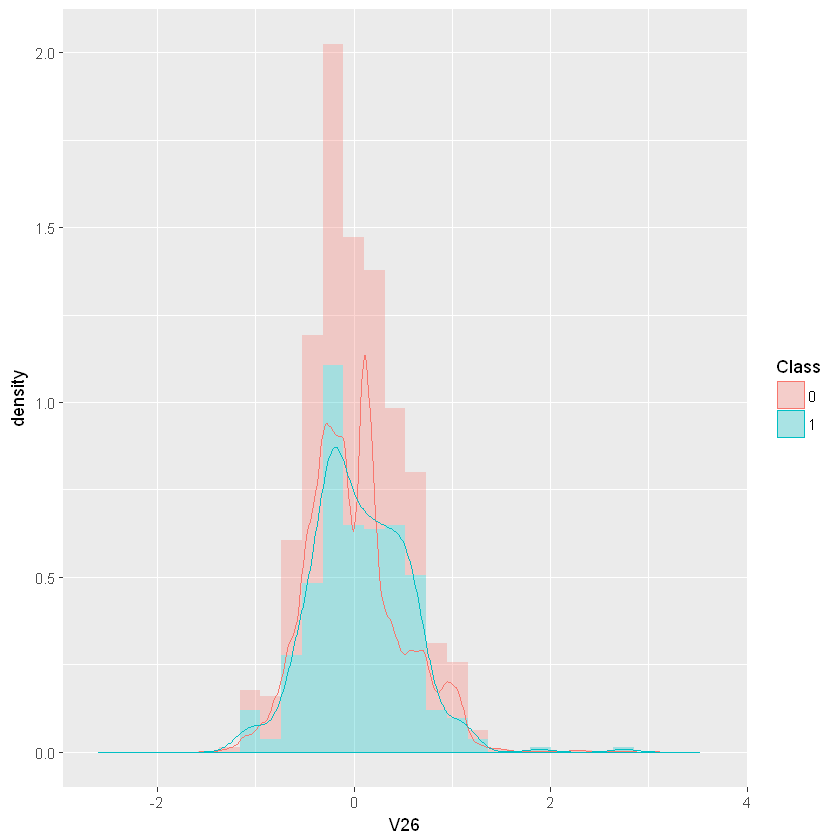

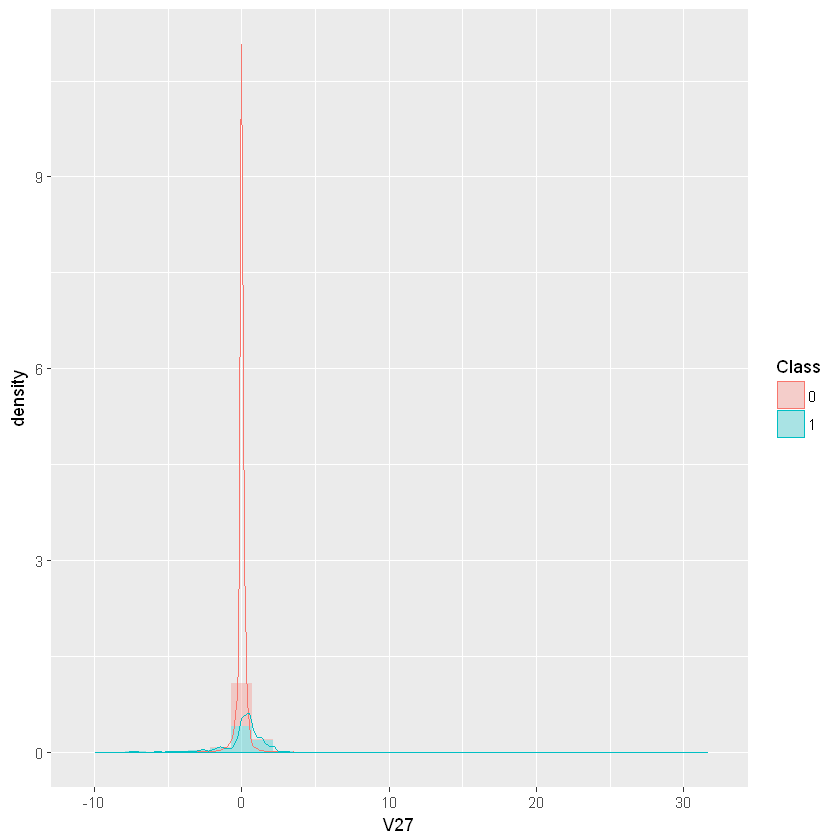

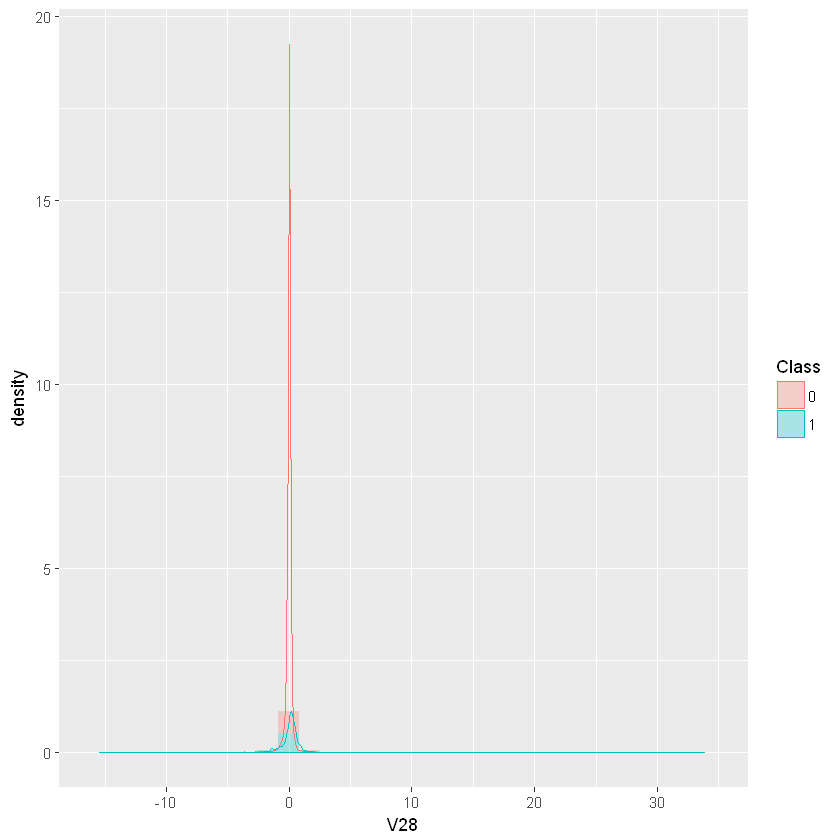

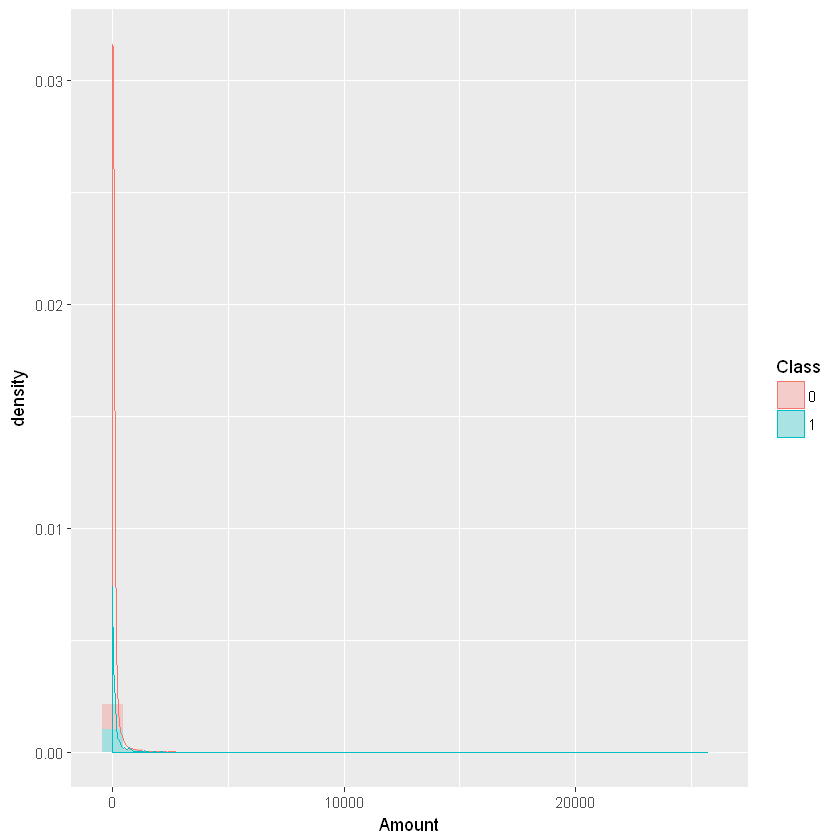

In [7]:
#p <- ggplot(df, aes_string)

for(col in names(df_train  %>% select(-Class))) {
    p <- ggplot(df_train, aes_string(col))
    print(p + 
            geom_histogram(aes(y = ..density.., fill = Class), bins = 30, alpha = 0.3) + 
            geom_density(aes(color = Class), alpha = 0))
}

#### Based on the above graphs, we may drop a few variables from the dataset that have a similar distribution (for ease of computation - this step may not be required with deep learning models), as having these in the model would not have any significant addition in value

In [ ]:
df_train <- df_train %>% 
    select(-V8,-V13,-V15,-V20,-V22,-V23,-V24,-V25,-V26,-V27,-V28)

df_test <- df_test %>% 
    select(-V8,-V13,-V15,-V20,-V22,-V23,-V24,-V25,-V26,-V27,-V28)

In [16]:
head(df_train)

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Class
3,1,-1.3583541,-1.3401631,1.7732093,0.3797796,-0.5031981,1.80049938,0.7914610,-1.5146543,0.2076429,0.6245015,0.06608369,-0.16594592,-2.89008319,1.10996938,-0.12135931,-2.26185710,0.247998153,378.66,0
5,2,-1.1582331,0.8777368,1.5487178,0.4030339,-0.4071934,0.09592146,0.5929407,0.8177393,0.7530744,-0.8228429,0.53819555,-1.11966983,-0.45144918,-0.23703324,-0.03819479,0.80348692,-0.009430697,69.99,0
6,2,-0.4259659,0.9605230,1.1411093,-0.1682521,0.4209869,-0.02972755,0.4762009,-0.5686714,-0.3714072,1.3412620,0.35989384,-0.13713370,0.40172590,-0.05813282,0.06865315,-0.03319379,-0.208253515,3.67,0
8,7,-0.6442694,1.4179635,1.0743804,-0.4921990,0.9489341,0.42811846,1.1206314,0.6153747,1.2493762,-0.6194678,0.29147435,-1.32386522,-0.07612700,-1.22212735,-0.35822157,0.32450473,1.943465340,40.80,0
9,7,-0.8942861,0.2861572,-0.1131922,-0.2715261,2.6695987,3.72181806,0.3701451,-0.3920476,-0.4104304,-0.7051166,-0.11045226,0.07435536,-0.21007727,-0.49976797,0.11876486,0.57032817,-0.073425100,93.20,0
11,10,1.4490438,-1.1763388,0.9138598,-1.3756667,-1.9713832,-0.62915214,-1.4232356,-1.7204084,1.6266591,1.1996439,-0.67143978,-0.09504505,0.03196747,0.25341472,0.85434381,-0.22136541,-0.009301897,7.80,0


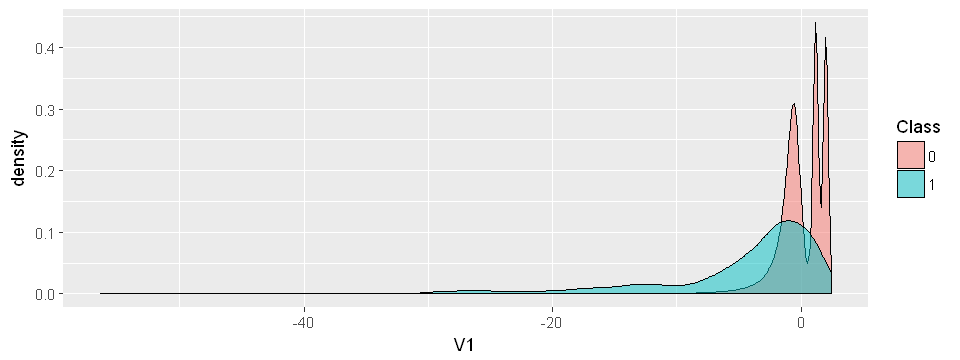

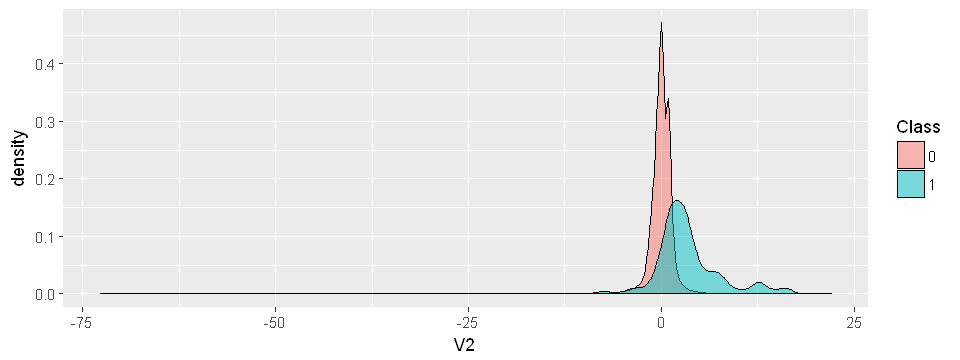

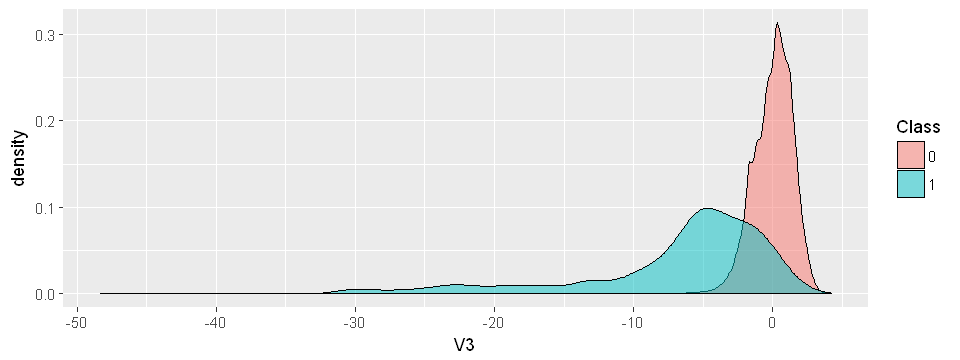

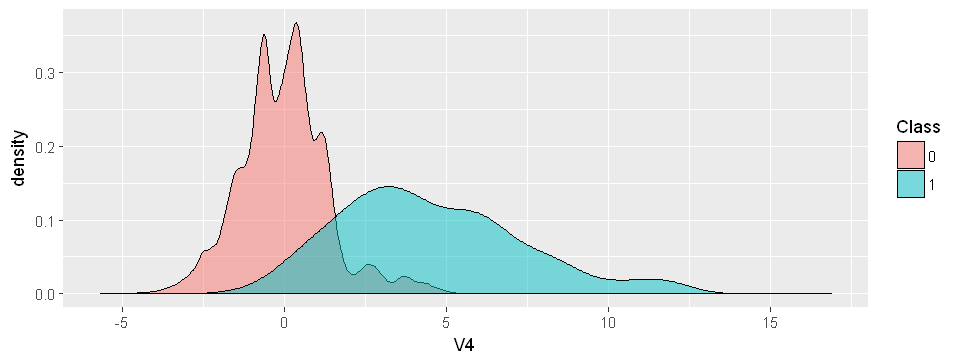

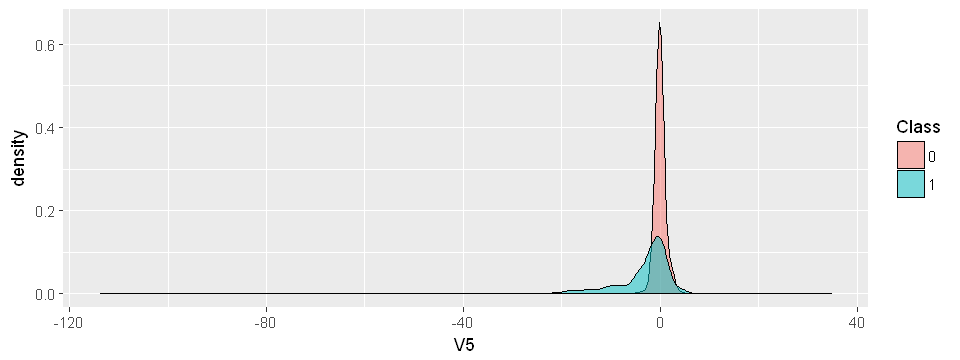

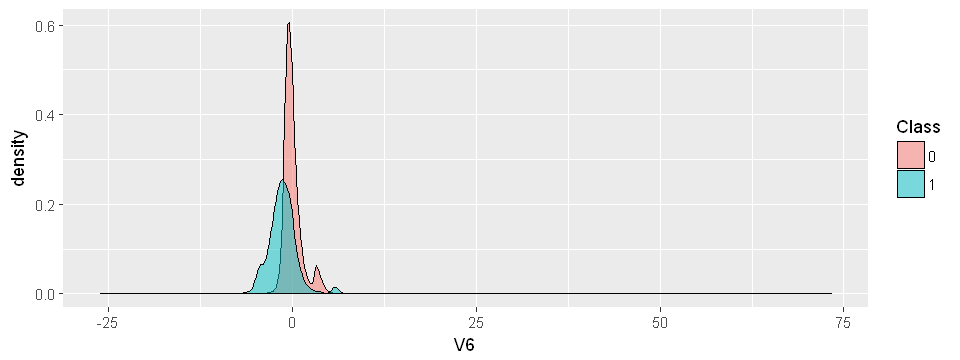

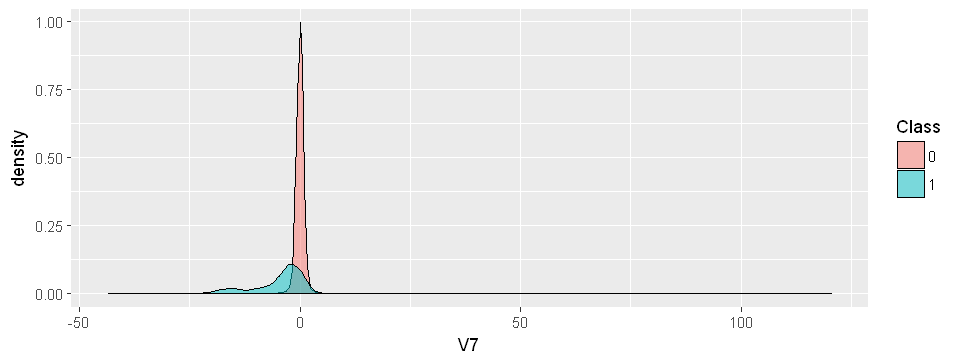

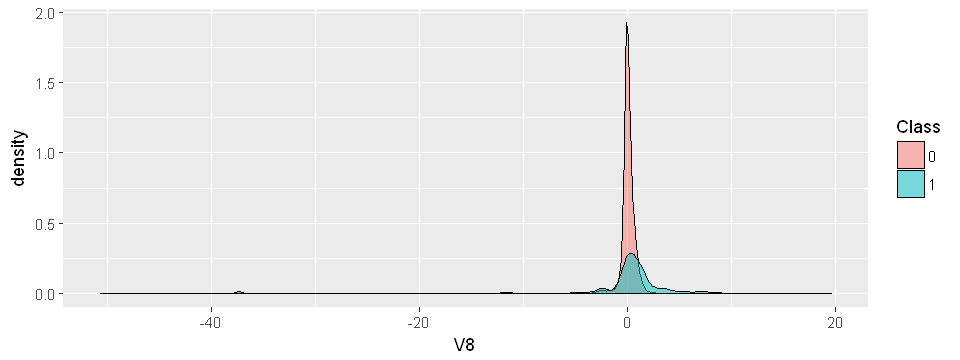

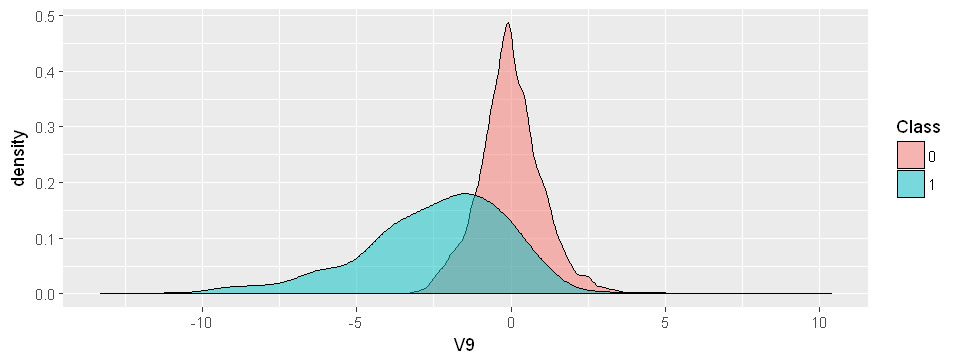

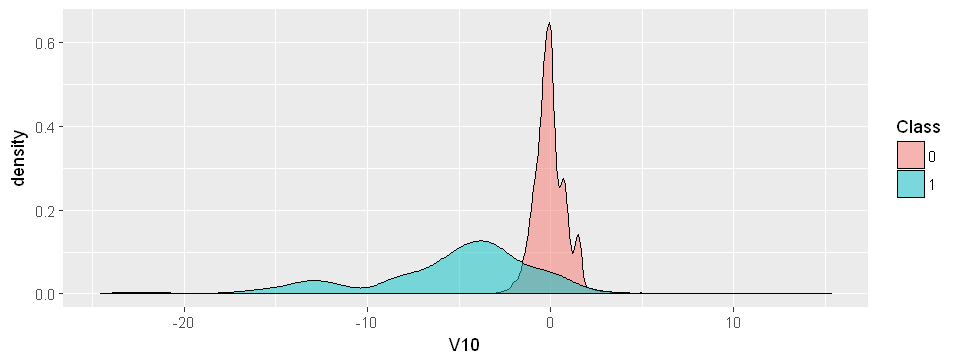

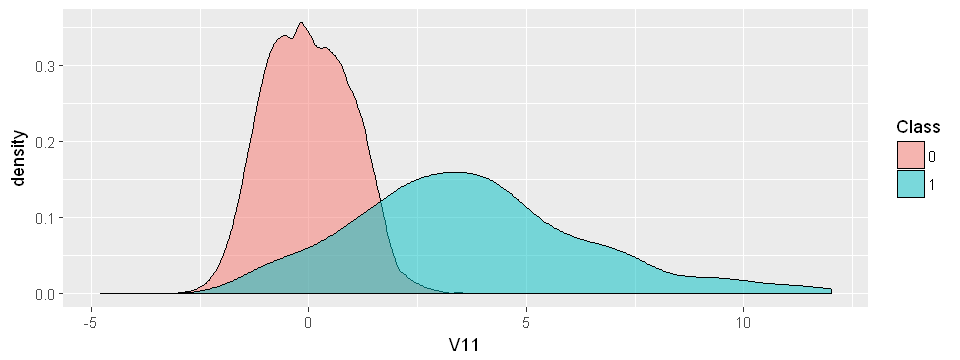

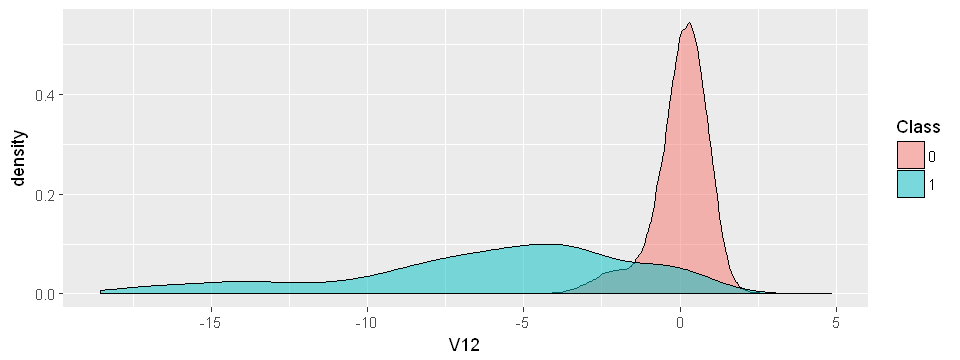

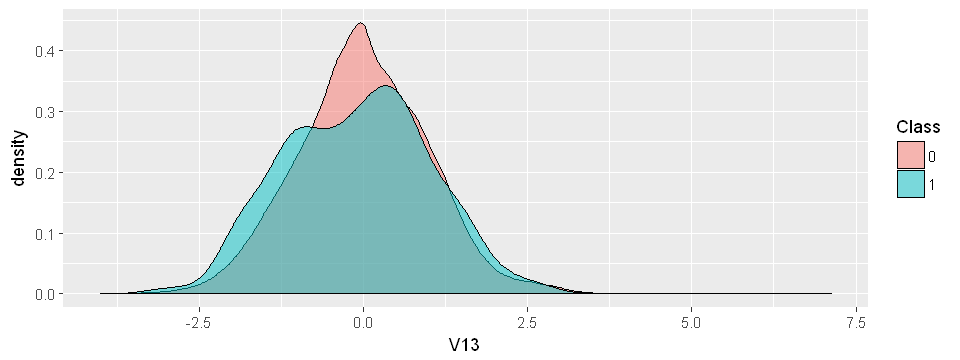

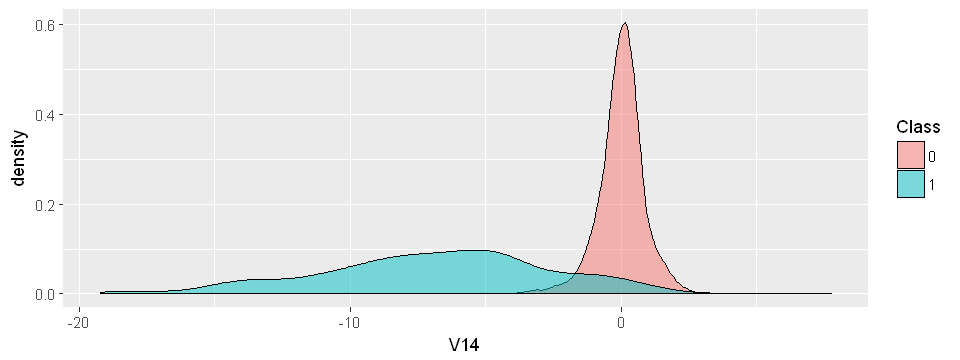

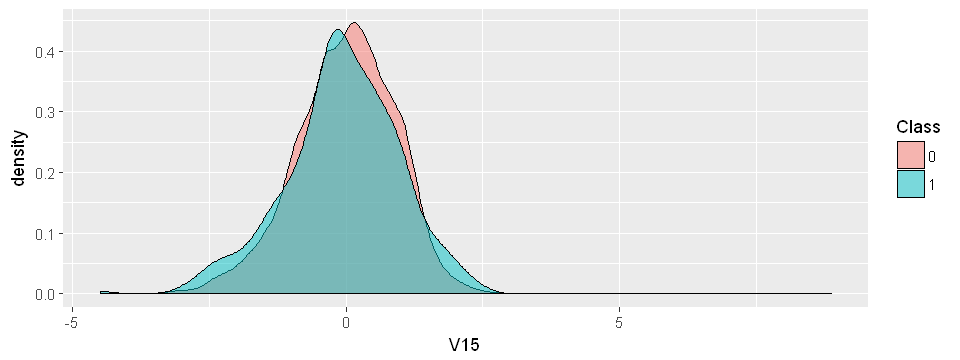

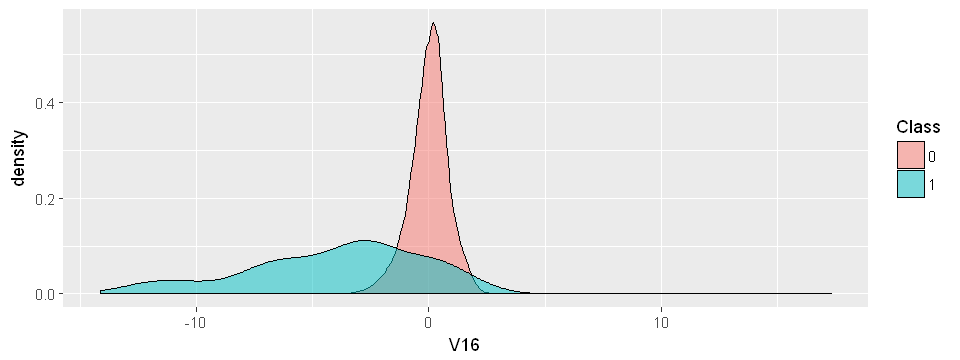

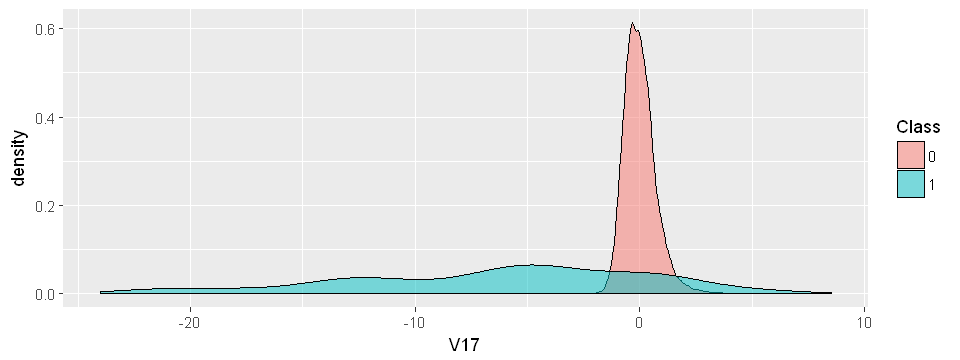

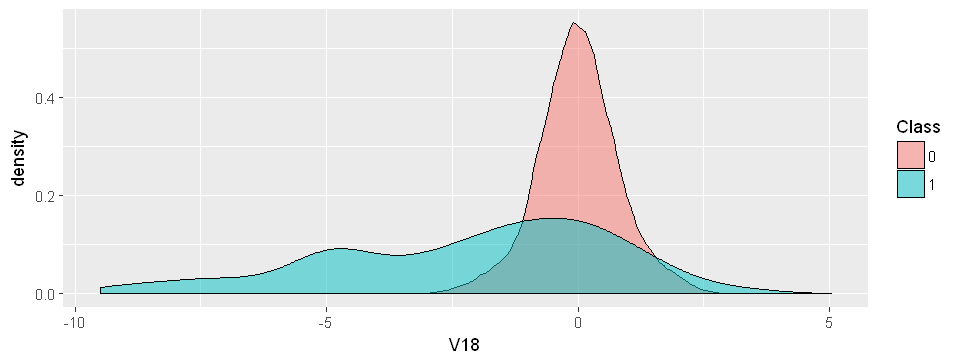

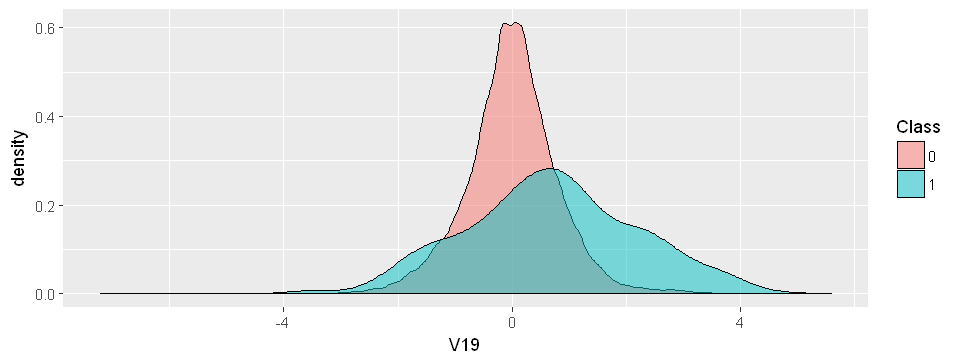

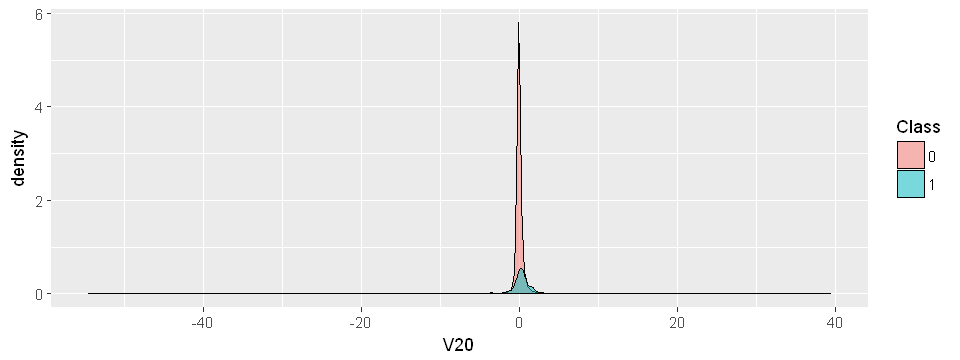

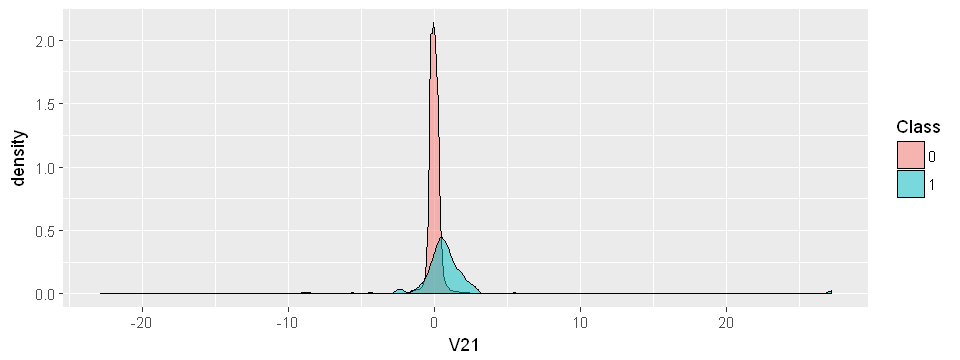

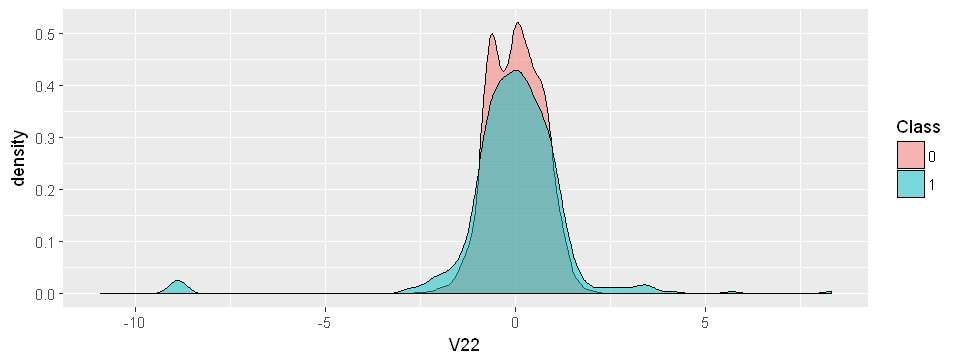

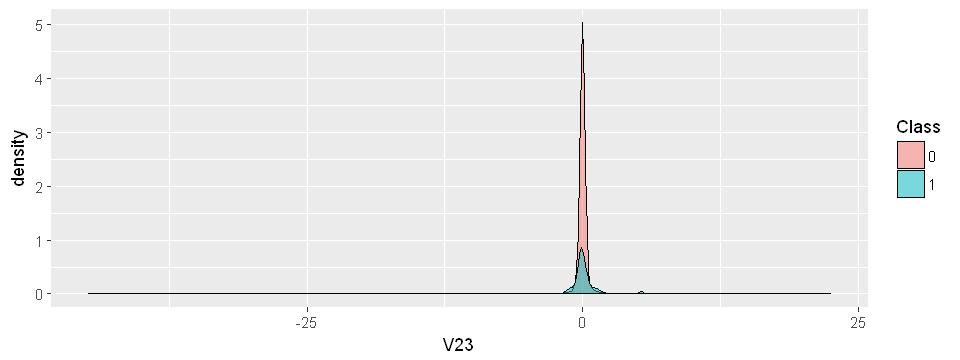

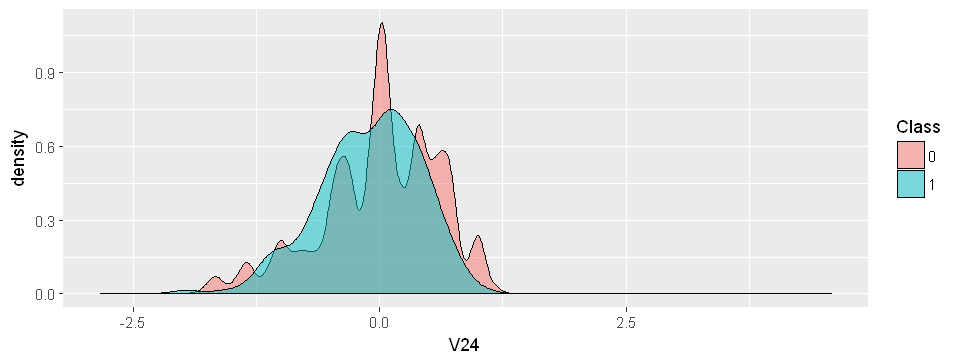

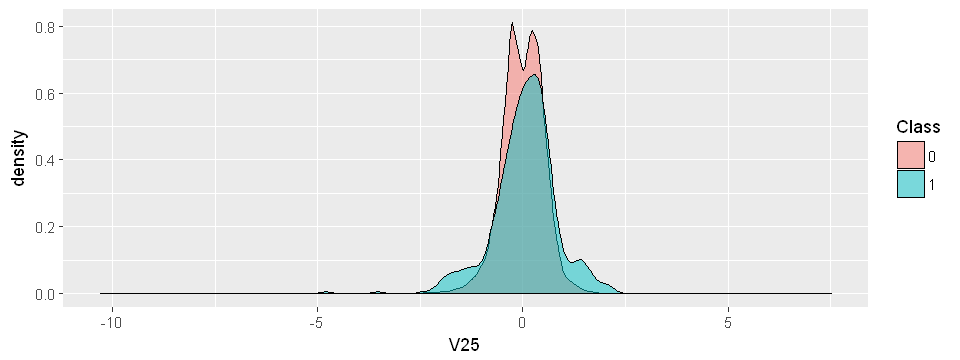

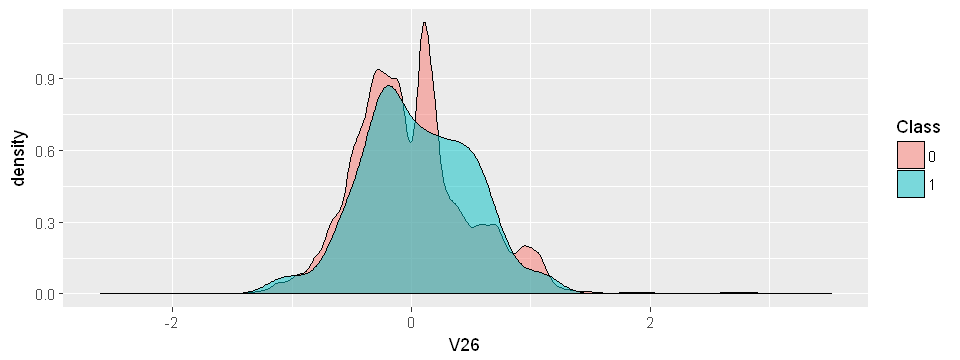

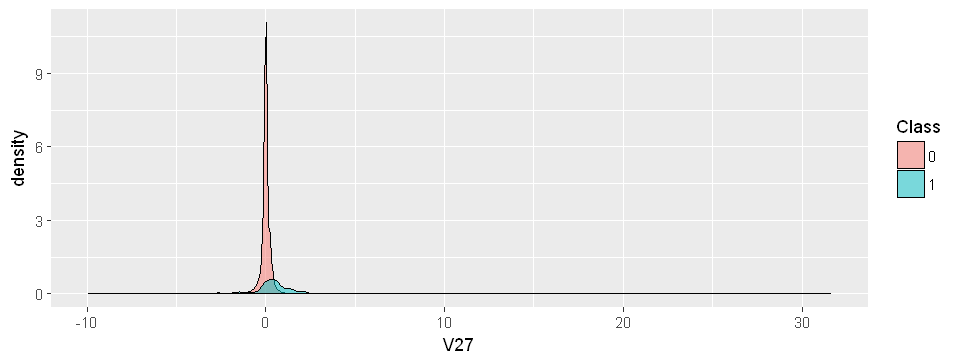

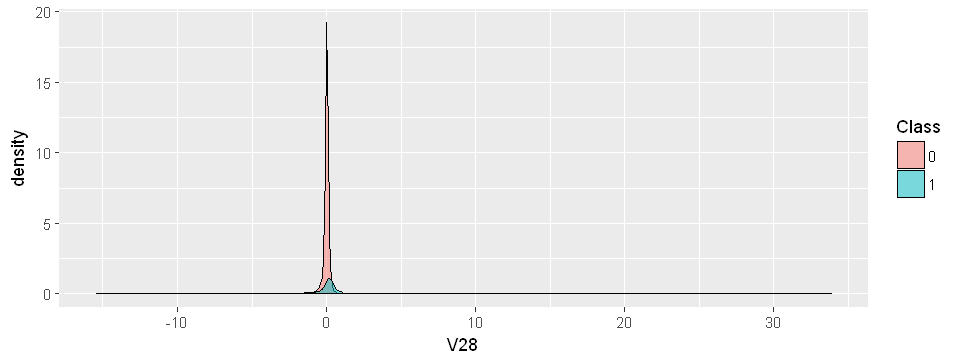

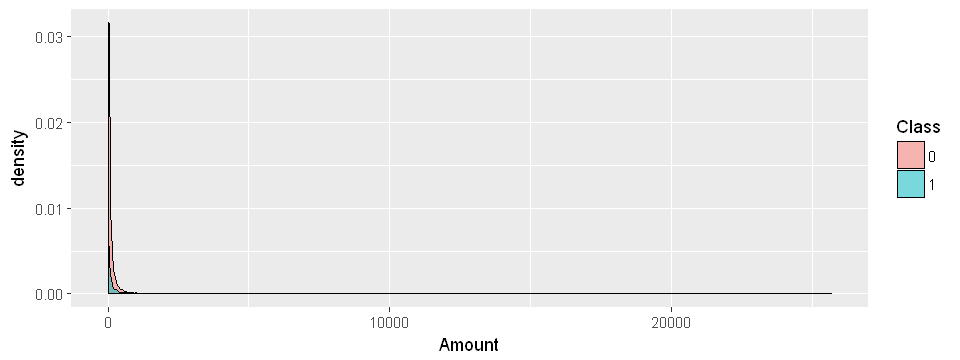

In [11]:
options(repr.plot.width = 8, repr.plot.height=3)

for(col in names(df_train %>% select(-Time,-Class))) {
    print(ggplot(df_train) + 
  geom_density(aes_string(col, fill = "Class"), alpha = 0.5)) 
}

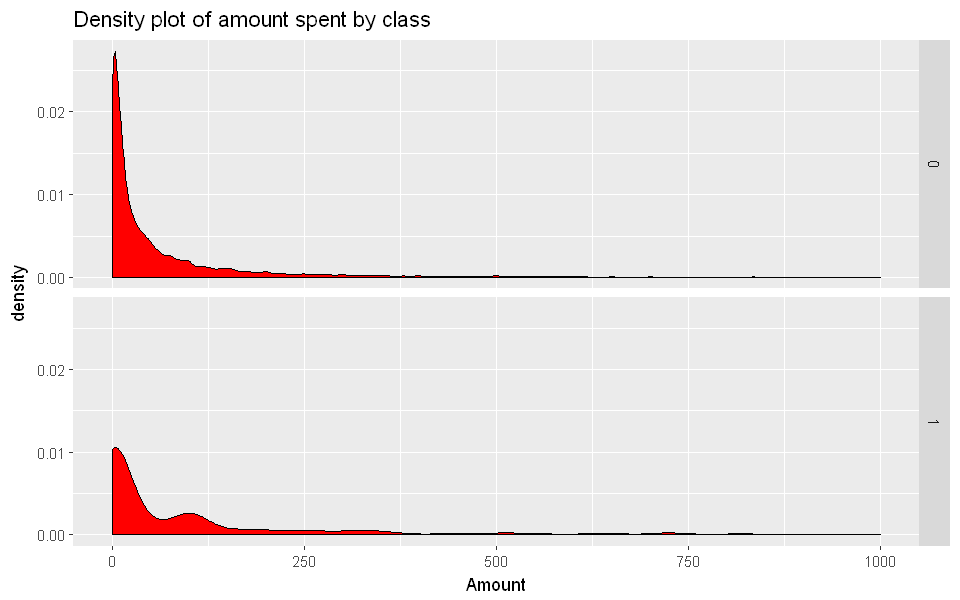

In [120]:
ggplot(df_train %>% filter(Amount < 1000)) + 
  geom_density(aes(Amount), fill = "red") + 
  facet_grid(Class ~ .) + 
  ggtitle("Density plot of amount spent by class")

--------------------------------------------------------------------------------------------------------------------------
#### Based on the distribution of variables across Fraudulent and normal transactions, we now create additional features that will help in training our models better
--------------------------------------------------------------------------------------------------------------------------

In [14]:
df_train <- df_train %>% 
  mutate(A1 = ifelse(V1 < 2,1,0),
         A2 = ifelse(V2 > 1.5,1,0),
         A3 = ifelse(V3 < 2,1,0),
         A4 = ifelse(V4 > 2.5,1,0),
         A5 = ifelse(V5 < -1.7,1,0),
         A6 = ifelse(V6 < -1.7,1,0),
         A7 = ifelse(V7 < -1.8,1,0),
         A9 = ifelse(V9 < -2,1,0),
         A10 = ifelse(V10 < -1.5,1,0),
         A11 = ifelse(V11 > 2.5,1,0),
         A12 = ifelse(V12 < -2.5,1,0),
         A14 = ifelse(V14 < -1.5,1,0),
         A16 = ifelse(V16 < -2,1,0),
         A17 = ifelse(V17 < -1,1,0),
         A18 = ifelse(V18 < -2.5,1,0),
         A19 = ifelse(V19 > 2,1,0),
         A21 = ifelse(V21 > 0.7,1,0))

df_test <- df_test %>% 
  mutate(A1 = ifelse(V1 < 2,1,0),
         A2 = ifelse(V2 > 1.5,1,0),
         A3 = ifelse(V3 < 2,1,0),
         A4 = ifelse(V4 > 2.5,1,0),
         A5 = ifelse(V5 < -1.7,1,0),
         A6 = ifelse(V6 < -1.7,1,0),
         A7 = ifelse(V7 < -1.8,1,0),
         A9 = ifelse(V9 < -2,1,0),
         A10 = ifelse(V10 < -1.5,1,0),
         A11 = ifelse(V11 > 2.5,1,0),
         A12 = ifelse(V12 < -2.5,1,0),
         A14 = ifelse(V14 < -1.5,1,0),
         A16 = ifelse(V16 < -2,1,0),
         A17 = ifelse(V17 < -1,1,0),
         A18 = ifelse(V18 < -2.5,1,0),
         A19 = ifelse(V19 > 2,1,0),
         A21 = ifelse(V21 > 0.7,1,0))


#### Let us visually check how our dependent variable is ditributed:

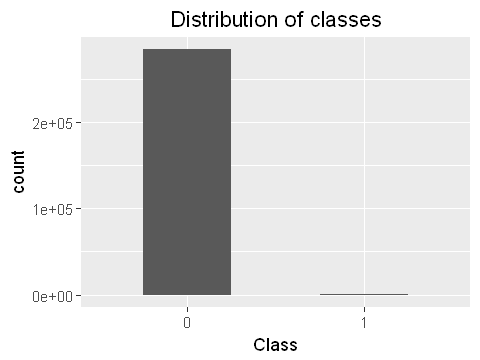

In [15]:
options(repr.plot.width=4, repr.plot.height=3)

ggplot(df) + 
  geom_bar(aes(x = Class), width = 0.5) + 
  ggtitle("Distribution of classes") + 
  theme(plot.title = element_text(hjust = 0.5))

In [16]:
table(df$Class)
table(df$Class)/nrow(df)


     0      1 
284315    492 


          0           1 
0.998272514 0.001727486 

#### Clearly, the dataset is highly imbalanced

Let us see how the transaction amounts vary between fraudulent and non-fraudulent transactions:

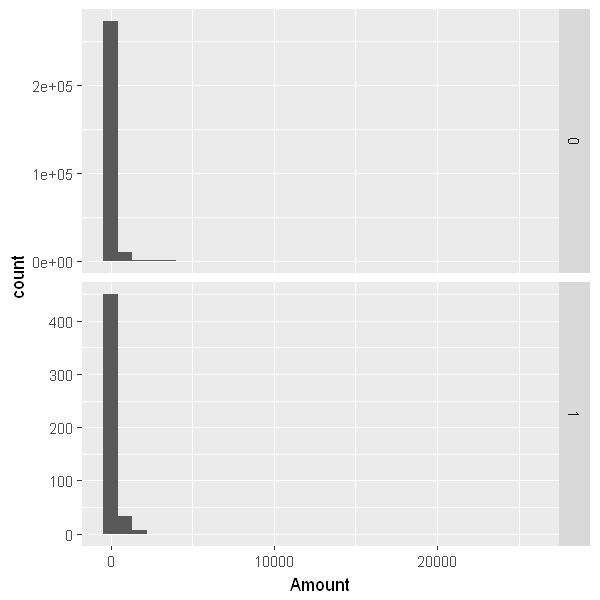

In [17]:
options(repr.plot.width = 5, repr.plot.height=5)

ggplot(df) + 
  geom_histogram(aes(Amount), bins = 30) + 
  facet_grid(Class ~ ., scales = "free")

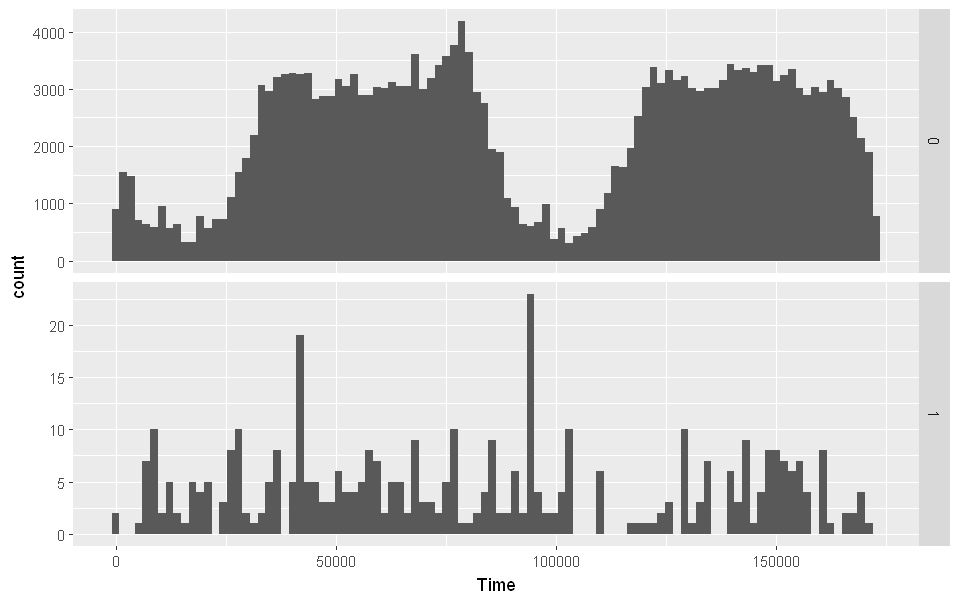

In [18]:
options(repr.plot.width = 8, repr.plot.height=5)

ggplot(df_train) + 
  geom_histogram(aes(Time), bins = 100) + 
  facet_grid(Class ~ ., scales = "free")

----------------------------------------------------------------------------------------------------------------------------
It is clear that the class is highly imbalanced. Therefore, it would be necessary to resample the dataset in such a way that the classes are balanced. There are a few ways to go about this. One option is doing undersampling (remove instances from the majority class to make the dataset balanced) or oversampling (replicate instances from the minority class to make the dataset balanced).

## Using the mlr package for 

### i. Over-sampling or under-sampling

In [19]:
table(df_train$Class)


     0      1 
227452    394 

In [20]:
table(df_test$Class)


    0     1 
56863    98 

#### We begin by creating what is known as a classification task:

In [14]:
#Create classification task
train_task <- makeClassifTask(data = df_train,
                             target = "Class")

#train_task <- oversample(train_task, rate = 10) #Oversample positive class by a ratio of 10
train_task <- undersample(train_task, rate = 1/100) #Undersample negative class by a ratio of 20

In [15]:
test_task <- makeClassifTask(data = df_test,
                            target = "Class")

In [23]:
table(train_task$env$data$Class) #See ratio of classes


   0    1 
2275  394 

## Enable use of all CPU cores

In [24]:
#Enable parallel processing, after automatic detection of CPU cores
parallelStop()
parallelStartSocket(cpus = detectCores())

Starting parallelization in mode=socket with cpus=4.


### Set 10-fold cross validation

In [29]:
inner <- makeResampleDesc("CV", iters = 10)

### Other resampling options

- Cross-validation ("CV"),
- Leave-one-out cross-validation ("LOO"),
- Subsampling, also called Monte-Carlo cross-validation ("Subsample"),
- Holdout (training/test) ("Holdout")

### Include cost sensitive classification

In [12]:
costs = matrix(c(0, 3, 5, 0), 2)
colnames(costs) = rownames(costs) = getTaskClassLevels(train_task)

th = costs[2,1]/(costs[2,1] + costs[1,2])
#th

credit.costs = makeCostMeasure(id = "credit.costs", 
                               name = "Credit costs", 
                               costs = costs,
                               best = 0, 
                               worst = 5)

costs

,0,1
0,0,5
1,3,0


### List other  available learners for classification

In [124]:
listMeasures("classif")

[1] "kappa"            "multiclass.brier" "fn"               "fp"              
 [5] "multiclass.aunp"  "brier.scaled"     "multiclass.aunu"  "bac"             
 [9] "qsr"              "brier"            "tnr"              "fdr"             
[13] "gmean"            "auc"              "tpr"              "ber"             
[17] "logloss"          "ppv"              "wkappa"           "mcc"             
[21] "timeboth"         "timepredict"      "acc"              "lsr"             
[25] "featperc"         "multiclass.au1p"  "multiclass.au1u"  "gpr"             
[29] "tn"               "tp"               "ssr"              "fnr"             
[33] "f1"               "fpr"              "npv"              "timetrain"       
[37] "mmce"

## Logistic regression

### Define learner (training model to be used) with type of feature selection

In [41]:
lrn <- makeFeatSelWrapper(learner = makeLearner("classif.logreg", 
                                                predict.type = "response"),
                          resampling = inner,
                          control = makeFeatSelControlSequential(method = "sfs"), #Sequential forward selection
                          show.info = FALSE,
                          measures = credit.costs)

### Train the model

In [42]:
mod <- train(learner = lrn, 
             task = train_task)

Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 4; elements = 10.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 4; elements = 47.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 4; elements = 46.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 4; elements = 45.


### Make predictions on the test dataset

In [43]:
pred <- predict(mod, 
                test_task)

### Check accuracy and misclassification costs for predictions

In [44]:
performance(pred, measure = list(credit.costs,acc))

credit.costs          acc 
  0.02261196   0.99541792

### Create Confusion Matrix from predictions

In [46]:
calculateConfusionMatrix(pred)

        predicted
true         0   1 -err.-
  0      56619 244    244
  1         17  81     17
  -err.-    17 244    261

## K-NN

In [47]:
knn_learn <- makeLearner("classif.kknn", predict.type = "response")

### Parameter tuning iterations

In [48]:
rancontrol <- makeTuneControlGrid()
set_cv <- makeResampleDesc("CV", iters = 10L)

### Set parameters of K-NN that needs to be tuned

In [49]:
knn_par <- makeParamSet(
  makeDiscreteParam("k", values = 5L:20L),
  makeDiscreteParam("distance", values = c(1L,2L))
)

#### Normalize features in the dataset

In [50]:
train_task_knn <- normalizeFeatures(train_task, method = "range") #Min-max normalization
test_task_knn <- normalizeFeatures(test_task, method = "range")

In [ ]:
set.seed(42)
#Enable parallel processing, after automatic detection of CPU cores
parallelStop()
parallelStartSocket(cpus = detectCores())

### Set type of grid search that needs to be carried out

In [54]:
rancontrol <- makeTuneControlGrid()  #makeTuneControlRandom() would do a random grid search

Stopped parallelization. All cleaned up.
Starting parallelization in mode=socket with cpus=4.


### Tune parameters

In [55]:
#rin = makeResampleInstance("CV", iters = 10, task = train_task)
tune_knn <- tuneParams(learner = knn_learn, 
                       task = train_task_knn,
                       resampling = makeResampleDesc("CV", iters = 10),
                       measures = credit.costs,
                       par.set = knn_par,
                       control = rancontrol
                       )

[Tune] Started tuning learner classif.kknn for parameter set:
             Type len Def                                   Constr Req Tunable
k        discrete   -   - 5,6,7,8,9,10,11,12,13,14,15,16,17,18,...   -    TRUE
distance discrete   -   -                                      1,2   -    TRUE
         Trafo
k            -
distance     -
With control class: TuneControlGrid
Imputation value: 5
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 4; elements = 32.
[Tune] Result: k=9; distance=1 : credit.costs.test.mean=0.0611


### Train the model with the selected parameters

In [56]:
final_knn <- setHyperPars(learner = knn_learn, par.vals = tune_knn$x)
to.knn <- train(final_knn, train_task_knn)

In [57]:
pred <- predict(to.knn, test_task_knn)

In [59]:
performance(pred, measures = list(credit.costs,acc))
calculateConfusionMatrix(pred)

credit.costs          acc 
   0.0345324    0.9929952

        predicted
true         0   1 -err.-
  0      56478 385    385
  1         14  84     14
  -err.-    14 385    399

## Random Forest

In [60]:
rf_learn <- makeLearner(cl = "classif.randomForest", 
                         predict.type = "response")

In [61]:
rancontrol <- makeTuneControlRandom(maxit = 50L)
set_cv <- makeResampleDesc("CV", iters = 10L)

In [62]:
#Define grid search parameters
rf_par <- makeParamSet(
  makeDiscreteParam("ntree", values = seq(100,500,20))
)

In [64]:
set.seed(42)
#Enable parallel processing, after automatic detection of CPU cores
parallelStop()
parallelStartSocket(cpus = detectCores())

tune_rf <- tuneParams(learner = rf_learn, 
                       task = train_task,
                       resampling = set_cv,
                       measures = credit.costs,
                       par.set = rf_par,
                       control = rancontrol)

Stopped parallelization. All cleaned up.
Starting parallelization in mode=socket with cpus=4.
[Tune] Started tuning learner classif.randomForest for parameter set:
          Type len Def                                   Constr Req Tunable
ntree discrete   -   - 100,120,140,160,180,200,220,240,260,2...   -    TRUE
      Trafo
ntree     -
With control class: TuneControlRandom
Imputation value: 5
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 4; elements = 50.
[Tune] Result: ntree=140 : credit.costs.test.mean=0.0641


In [67]:
final_rf <- setHyperPars(learner = rf_learn, par.vals = tune_rf$x)
to.rf <- train(final_rf, train_task)

In [68]:
#Make predictions
rfpred <- predict(to.rf, test_task)

In [69]:
performance(rfpred, measures = list(credit.costs,acc))
calculateConfusionMatrix(rfpred)

credit.costs          acc 
  0.01688875   0.99652394

        predicted
true         0   1 -err.-
  0      56679 184    184
  1         14  84     14
  -err.-    14 184    198

## Gradient Boosted Model

In [70]:
gbm_learn <- makeLearner(cl = "classif.gbm", 
                         predict.type = "response")

rancontrol <- makeTuneControlRandom(maxit = 50L)
set_cv <- makeResampleDesc("CV", iters = 10L)

In [75]:
#Define grid search parameters
gbm_par <- makeParamSet(
  makeIntegerParam("n.trees", lower = 100, upper = 500), #number of trees
  makeIntegerParam("interaction.depth", lower = 2, upper = 10), #depth of tree
  makeIntegerParam("n.minobsinnode", lower = 10, upper = 15),
  makeNumericParam("shrinkage",lower = 0.01, upper = 1)
)

In [76]:
set.seed(42)
#Enable parallel processing, after automatic detection of CPU cores
parallelStop()
parallelStartSocket(cpus = 3)

tune_gbm <- tuneParams(learner = gbm_learn, 
                       task = train_task,
                       resampling = set_cv,
                       measures = credit.costs,
                       par.set = gbm_par,
                       control = rancontrol)

Stopped parallelization. All cleaned up.
Starting parallelization in mode=socket with cpus=3.
[Tune] Started tuning learner classif.gbm for parameter set:
                     Type len Def     Constr Req Tunable Trafo
n.trees           integer   -   - 100 to 500   -    TRUE     -
interaction.depth integer   -   -    2 to 10   -    TRUE     -
n.minobsinnode    integer   -   -   10 to 15   -    TRUE     -
shrinkage         numeric   -   -  0.01 to 1   -    TRUE     -
With control class: TuneControlRandom
Imputation value: 5
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 3; elements = 50.
[Tune] Result: n.trees=402; interaction.depth=8; n.minobsinnode=13; shrinkage=0.262 : credit.costs.test.mean=0.0689


In [77]:
final_gbm <- setHyperPars(learner = gbm_learn, 
                          par.vals = tune_gbm$x)

to.gbm <- train(final_gbm, train_task)

Distribution not specified, assuming bernoulli ...


In [78]:
#Make predictions
gbpred <- predict(to.gbm, test_task)

In [80]:
performance(gbpred, measures = list(credit.costs,acc))
calculateConfusionMatrix(gbpred)

credit.costs          acc 
  0.02498201   0.99492635

        predicted
true         0   1 -err.-
  0      56585 278    278
  1         11  87     11
  -err.-    11 278    289

## XGBoost

In [81]:
#Define the learner
lrn <- makeLearner(cl = "classif.xgboost", predict.type = "response")

#Define grid search parameters
params <- makeParamSet(
         makeIntegerParam("max_depth",lower = 3L,upper = 10L),
         makeIntegerParam("min_child_weight",lower = 1L,upper = 10L),
         makeDiscreteParam("subsample",values = seq(0.5,1,0.1)),
         makeDiscreteParam("colsample_bytree",values = seq(0.5,1,0.1)),
         makeDiscreteParam("eta", values = seq(0.01,0.1,0.01)),
         makeDiscreteParam("nrounds", values = seq(100L, 1000L, by = 50L))
)

In [82]:
#Set type of resampling
rdesc <- makeResampleDesc("CV", iters = 10L)
ctrl <- makeTuneControlRandom(maxit = 50L)

In [84]:
set.seed(42)

#Enable parallel processing, after automatic detection of CPU cores
parallelStop()
parallelStartSocket(cpus = detectCores())

#lrn$par.vals <- list(
#               objective= "classif:linear",
#               eval_metric= "mae")
  
mytune <- tuneParams(learner = lrn,
               task = train_task,
               resampling = rdesc,
               measures = credit.costs,
               par.set = params,
               control = ctrl,
               show.info = TRUE)

Stopped parallelization. All cleaned up.
Starting parallelization in mode=socket with cpus=4.
[Tune] Started tuning learner classif.xgboost for parameter set:
                     Type len Def                                   Constr Req
max_depth         integer   -   -                                  3 to 10   -
min_child_weight  numeric   -   -                                  1 to 10   -
subsample         numeric   -   -                                 0.5 to 1   -
colsample_bytree  numeric   -   -                                 0.5 to 1   -
eta               numeric   -   -                              0.01 to 0.1   -
nrounds          discrete   -   - 100,150,200,250,300,350,400,450,500,5...   -
                 Tunable Trafo
max_depth           TRUE     -
min_child_weight    TRUE     -
subsample           TRUE     -
colsample_bytree    TRUE     -
eta                 TRUE     -
nrounds             TRUE     -
With control class: TuneControlRandom
Imputation value: 5
Exporting obj

In [85]:
#Set parameters as defined by grid search in previous step
lrn_tune <- setHyperPars(lrn,
                         par.vals = mytune$x,
                         print_every_n = 100)

In [86]:
#Fit the X-gradient boosted model
set.seed(42)

xgmodel <- train(learner = lrn_tune,
                 task = train_task)

In [90]:
xgpred <- predict(xgmodel,test_task)

In [92]:
performance(xgpred, measures = list(credit.costs,acc))
calculateConfusionMatrix(xgpred)

credit.costs          acc 
  0.02231351   0.99545303

        predicted
true         0   1 -err.-
  0      56616 247    247
  1         12  86     12
  -err.-    12 247    259

In [115]:
#class(xgmodel$learner.model)
#xgb.save(xgmodel$learner.model, "credit-cards-xgb-model.model")

[1] TRUE